In [57]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [58]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0, 1/3, 20)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

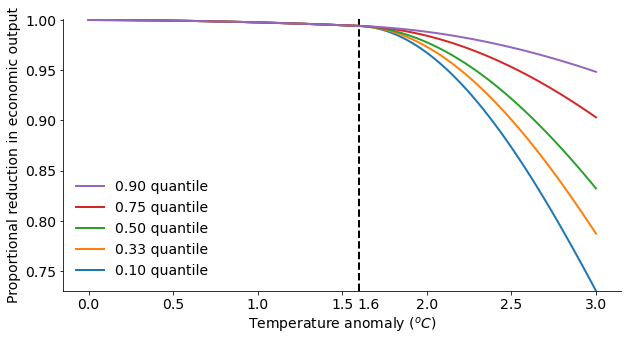

In [59]:
# 1.6
y_jump=1.6

fig  = plt.figure(figsize=(10, 5))
y_arr  = np.linspace(0,3, 100)
# damage =  γ1*y + γ2/2*y_arr**2 + γ3_list/2*(y_arr - y_jump)**2*(y_arr >= y_jump)

damage = np.zeros((len(γ3_list), len(y_arr)))
for i in range(len(γ3_list)):
        damage[i] = γ1*y_arr + γ2/2*y_arr**2 + γ3_list[i]/2*(y_arr - y_jump)**2*(y_arr >= y_jump)
        
quant_list = [0.1, 0.33, 0.5, 0.75, 0.9] 
damage_quant = np.zeros((5, len(y_arr)))
for j in range(len(quant_list)):
        damage_quant[j] = np.quantile(np.exp(-damage), quant_list[j], axis=0)
        plt.plot(y_arr, damage_quant[j], label="{:.2f} quantile".format(quant_list[j]))

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=3)        
# plt.legend()
plt.xlabel("Temperature anomaly $(^o C)$")
plt.ylabel("Proportional reduction in economic output")
plt.vlines(1.6, ymin=0.73, ymax=1+0.001, color="black", linestyle="dashed")
plt.text(1.6-0.01, 0.7+0.0121, 1.6, )
plt.ylim(np.min(damage_quant), np.max(damage_quant)+0.001)

# plt.title("Damage specifications, ȳ = {}".format(y_jump))
plt.savefig("damage_1_6.pdf", facecolor="w", edgecolor="w", dpi=500)

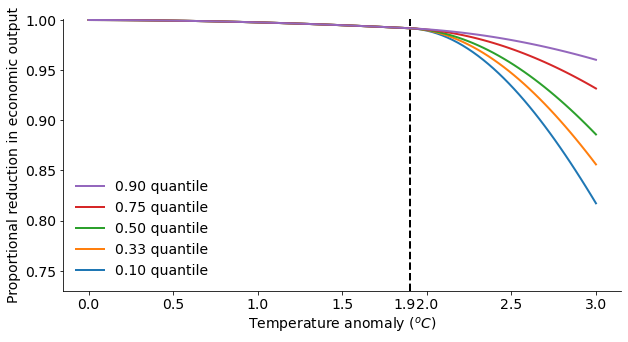

In [60]:
# 1.9
y_jump=1.9

fig  = plt.figure(figsize=(10, 5))
y_arr  = np.linspace(0,3, 100)
# damage =  γ1*y + γ2/2*y_arr**2 + γ3_list/2*(y_arr - y_jump)**2*(y_arr >= y_jump)

damage = np.zeros((len(γ3_list), len(y_arr)))
for i in range(len(γ3_list)):
        damage[i] = γ1*y_arr + γ2/2*y_arr**2 + γ3_list[i]/2*(y_arr - y_jump)**2*(y_arr >= y_jump)
        
quant_list = [0.1, 0.33, 0.5, 0.75, 0.9] 
damage_quant = np.zeros((5, len(y_arr)))
for j in range(len(quant_list)):
        damage_quant[j] = np.quantile(np.exp(-damage), quant_list[j], axis=0)
        plt.plot(y_arr, damage_quant[j], label="{:.2f} quantile".format(quant_list[j]))

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 3, 2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=3)              
plt.xlabel("Temperature anomaly $(^o C)$")
plt.ylabel("Proportional reduction in economic output")
plt.vlines(1.9, ymin=0.73, ymax=1+ 0.005, color="black", linestyle="dashed")
plt.text(1.9-0.096, 0.73-0.018, 1.9, )
plt.ylim(0.73, np.max(damage_quant)+0.001)

# plt.title("Damage specifications, ȳ = {}".format(y_jump))
plt.savefig("damage_1_9.pdf", facecolor="w", edgecolor="w", dpi=500)

In [61]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt


def simulate_ems_step1(ems, loc, T=100, dt=1):
    y_grid_pre = y_grid[:loc+1]
    periods = int(T/dt)
    yt = np.zeros(periods)
    et = np.zeros(periods)
    y = 1.1
    for t in range(periods):
        if y < y_grid[loc]:
            e_i = np.interp(y, y_grid_pre, ems)
            et[t] = e_i
            yt[t] = y
            y  = y + e_i*np.mean(θ_list)*dt
    return et, yt

In [62]:
logkt = simulate_logkapital(invkap, αₖ, σₖ, κ, k0 = 80/α)

In [63]:
# γ3_list_test = γ3_list[[0,1,2,-1]]
# γ3_list = γ3_list_test

In [64]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [65]:
from multiprocessing import Pool
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [66]:
args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], 2, ξa, ξw )
solution_low = solve_smooth_100(y_grid, args_low, max_iter=4000, tol=1e-7, ϵ=1.0)

episode: 4000,	 ode error: 0.0001364390034401114,	 ft error: 3.843588798702058e-05


In [67]:
jump_extension = np.arange(y_bar+ hy, 2.5+hy, hy)

In [68]:
args_list_ex = []
for y_tilde in jump_extension:
    for γ3_i in γ3_list[1:]:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        args_iter = (y_grid, args_func, 2000, 1e-7, 0.5)
        args_list_ex.append(args_iter)

        
start = time.time()
res_list_ex = ode_y_parallel(args_list_ex)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

'00h36m32s'

In [69]:
args_list = []
for y_tilde in jump_interval:
    for γ3_i in γ3_list[1:]:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        args_iter = (y_grid, args_func, 5000, 1e-7, 0.5)
        args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        
#         ϕ, ems, _, _ = solve_smooth_100()
#         ϕ_list.append(ϕ)
#         e_list.append(ems)
#     ϕ_list = np.array(ϕ_list)
#     e_list = np.array(e_list)
#     res_list.append((ϕ_list, e_list))

In [70]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

'00h51m10s'

In [71]:
# pickle.dump(res_list, open("../data/damage_prep_40_0.01.p", "wb"))

In [72]:
res_dict = pickle.load(open('../../damage_prep_40_tight.p', 'rb'))

ϕ_ref = res_dict['φ_ref']
ems_ref = res_dict['ems_ref']
res_list = res_dict['res_list']
ems_list = res_dict['ems_list']

FileNotFoundError: [Errno 2] No such file or directory: '../../damage_prep_40_tight.p'

In [73]:
# construct ϕ_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [74]:
ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

count = 0
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
    ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
    for j in range(len(γ3_list[1:])):
        ϕ_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
        ems_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [75]:
ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_list[i, 0] = solution_low['φ']
    ems_list[i, 0] = solution_low['ems']
    for j in range(len(γ3_list[1:])):
        ϕ_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['φ']
        ems_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['ems']

In [76]:
# res_dict = dict(res_list=res_list, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
# pickle.dump(res_dict, open("../data/damage_prep_40_tight.p", "wb"))

In [77]:
len(res_list)/39

12.666666666666666

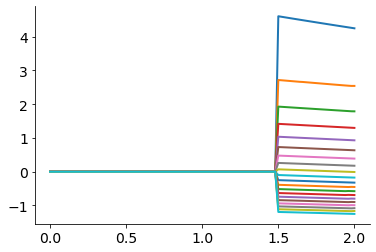

In [78]:
plt.plot(pre_jump,ϕ_ref.T)
plt.show()

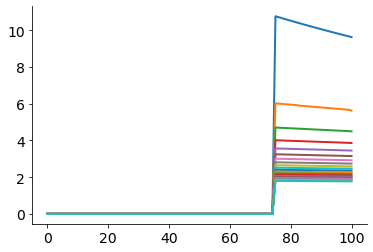

In [79]:
plt.plot(ems_ref.T)
plt.show()

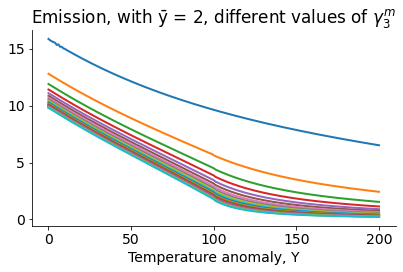

In [80]:
for i in range(len(dmg_weight)):
    plt.plot(ems_list[-1, i, :])
plt.xlabel('Temperature anomaly, Y')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

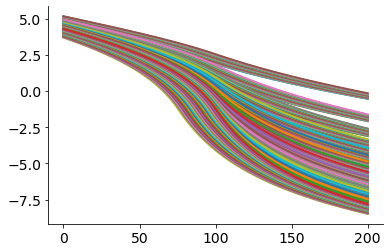

In [81]:
for i in range(len(res_list)):
    plt.plot(res_list[i]['φ'])

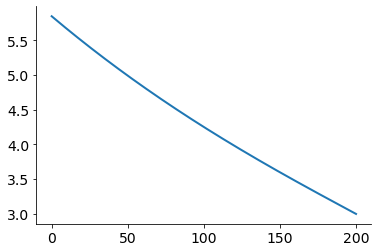

In [82]:
plt.plot(solution_low['φ'])

In [83]:
ϕ_ref.shape

(20, 101)

In [84]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

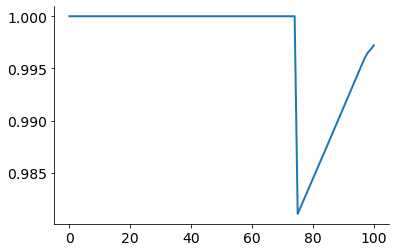

In [85]:
plt.plot(weighted)

In [86]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
# r0 = 1/(float(ans[-1])**4 - 1)/τ
r0 = - 0.4

In [87]:
r0, r1

(-0.4, -19.5000916299522)

In [88]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [89]:
ϕ_low = solution_low['φ']
ϕ_list_no_low = np.zeros((len(γ3_list[1:]), len(ϕ_low)))
for i in range(len(γ3_list[1:])):
    ϕ_list_no_low[i] = res_list[-(len(γ3_list[1:]) - i)]['φ']

In [90]:
ϕ_list_no_low[-1, :numy_bar+1], ϕ_ref[-1]

(array([ 4.29612182,  4.26594833,  4.23565081,  4.20522756,  4.17467581,
         4.14399196,  4.11317153,  4.08221025,  4.0511037 ,  4.01984734,
         3.9884365 ,  3.95686639,  3.92513209,  3.89322853,  3.86115054,
         3.82889275,  3.79644969,  3.76381569,  3.73098496,  3.69795149,
         3.66470915,  3.63125158,  3.59757226,  3.56366445,  3.52952121,
         3.49513539,  3.46049961,  3.42560625,  3.39044746,  3.35501513,
         3.31930086,  3.28329599,  3.24699158,  3.21037837,  3.17344678,
         3.13618689,  3.09858844,  3.06064081,  3.02233298,  2.98365353,
         2.94459063,  2.90513198,  2.86526483,  2.82497594,  2.78425155,
         2.74307733,  2.70143842,  2.65931933,  2.61670392,  2.5735754 ,
         2.52991626,  2.48570823,  2.44093225,  2.39556842,  2.34959593,
         2.30299303,  2.25573698,  2.20780394,  2.15916895,  2.10980584,
         2.05968715,  2.00878402,  1.95706615,  1.90450165,  1.85105697,
         1.79669672,  1.74138362,  1.68507828,  1.6

In [91]:
ϕ_list2 = np.concatenate(([ϕ_low], ϕ_list_no_low), axis=0)

In [92]:
ϕ_list2.shape

(20, 201)

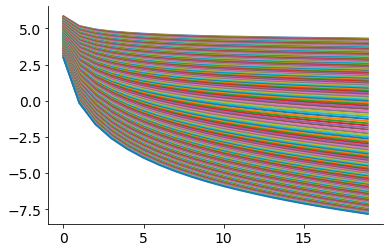

In [93]:
plt.plot(ϕ_list2)
plt.show()

In [94]:
ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list2), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(ϕ_average2)
ϕ_bound.shape

(201,)

In [156]:
# ξa=0.01
# ξp=5
ξa=0.01
ξp=1000

σy = 1.2*np.mean(θ_list)

numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
intensity = 5*(np.exp(5/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
# intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

AA = 30
# intensity =( 0.5*AA*(y_grid_cap-1.5)**2)*( y_grid_cap > 1.5)
dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]



# ϕ = -η*(y_grid_cap + y_grid_cap**2)

dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)

ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list2), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(ϕ_average2)
# ϕ_bound = np.average(ϕ_list2, weights=dmg_weight, axis=0)

tol= 1e-8
ϵ = 1.0
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)  
    
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
        
#     ems_new = -b/c
#     ems_new[ems_new < 1e-20] = 1e-20
    ems = ems_new*0.05 + ems_old*0.95
    
    
    ϕ_ref_short = ϕ_ref[:, :]
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref_short))
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)  - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2*np.ones(np.size(By))
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*(ϕ_ref_short)))
    # solver
    
    ϕ_new = false_transient_one_iteration_python(A, By, Cyy, D, ϕ, ϵ,dy,(0,ϕ_bound[numy_bar]), (False, True))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.7206741805681065,	 ft error: 0.4845319966591808
episode: 2,	 ode error: 0.7584363423920572,	 ft error: 0.2697324936024623
episode: 3,	 ode error: 0.781091440022998,	 ft error: 0.18556899093229395
episode: 4,	 ode error: 0.7960041401217894,	 ft error: 0.1414860480533361
episode: 5,	 ode error: 0.8013154321944536,	 ft error: 0.11561628308705696
episode: 6,	 ode error: 0.8047514024350086,	 ft error: 0.09879411293119456
episode: 7,	 ode error: 0.8072613016894968,	 ft error: 0.08556925535981574
episode: 8,	 ode error: 0.8091789616428489,	 ft error: 0.07728876923192651
episode: 9,	 ode error: 0.8106843907542908,	 ft error: 0.0695427582565129
episode: 10,	 ode error: 0.8118901605538529,	 ft error: 0.06433797796557483
episode: 11,	 ode error: 0.8128712057109047,	 ft error: 0.060223326376913744
episode: 12,	 ode error: 0.8136795230097368,	 ft error: 0.056131303752218864
episode: 13,	 ode error: 0.8143524215826372,	 ft error: 0.05263876340752227
episode: 14,	 ode error:

episode: 114,	 ode error: 0.8186703859929539,	 ft error: 0.006697240159607265
episode: 115,	 ode error: 0.8186704802602569,	 ft error: 0.006603883414133094
episode: 116,	 ode error: 0.818670569437673,	 ft error: 0.0065145221274671705
episode: 117,	 ode error: 0.8186706538140542,	 ft error: 0.006426853371403141
episode: 118,	 ode error: 0.8186707336609452,	 ft error: 0.006337973603707248
episode: 119,	 ode error: 0.8186708092326499,	 ft error: 0.006253628073830786
episode: 120,	 ode error: 0.8186708807669785,	 ft error: 0.006170102304398739
episode: 121,	 ode error: 0.8186709484906106,	 ft error: 0.006085813546062191
episode: 122,	 ode error: 0.8186710126157565,	 ft error: 0.006005365454751832
episode: 123,	 ode error: 0.8186710733398176,	 ft error: 0.005926082627932594
episode: 124,	 ode error: 0.8186711308502226,	 ft error: 0.005846355857253904
episode: 125,	 ode error: 0.8186711853231683,	 ft error: 0.005768879510560598
episode: 126,	 ode error: 0.8186712369221623,	 ft error: 0.00569

episode: 227,	 ode error: 0.8186721580739531,	 ft error: 4.829061542022117e-05
episode: 228,	 ode error: 0.8186721596424771,	 ft error: 4.96281995848169e-05
episode: 229,	 ode error: 0.8186721605019932,	 ft error: 4.2959254211716313e-05
episode: 230,	 ode error: 0.8186721615356735,	 ft error: 4.0293483810849295e-05
episode: 231,	 ode error: 0.8186721620903052,	 ft error: 3.7666512997525103e-05
episode: 232,	 ode error: 0.8186721624366924,	 ft error: 5.181399904113926e-05
episode: 233,	 ode error: 0.8186721614272426,	 ft error: 3.965135006117615e-05
episode: 234,	 ode error: 0.8186721632018112,	 ft error: 3.0218325711928173e-05
episode: 235,	 ode error: 0.8186721637850719,	 ft error: 4.862613723011222e-05
episode: 236,	 ode error: 0.8186721619528932,	 ft error: 3.790656193058961e-05
episode: 237,	 ode error: 0.8186721648700486,	 ft error: 2.3674494149972247e-05
episode: 238,	 ode error: 0.8186721658035417,	 ft error: 2.1722611312391393e-05
episode: 239,	 ode error: 0.8186721660875571,	 

episode: 345,	 ode error: 0.8186721766754722,	 ft error: 3.798020912743061e-05
episode: 346,	 ode error: 0.8186721367387121,	 ft error: 3.588103944041077e-05
episode: 347,	 ode error: 0.8186721699026396,	 ft error: 9.392534803032149e-06
episode: 348,	 ode error: 0.8186721743927556,	 ft error: 3.1278311746762988e-06
episode: 349,	 ode error: 0.8186721840187396,	 ft error: 4.852117674092327e-06
episode: 350,	 ode error: 0.8186721534053035,	 ft error: 4.8071452186548846e-05
episode: 351,	 ode error: 0.8186721611573715,	 ft error: 1.2071606267427537e-05
episode: 352,	 ode error: 0.8186721986860422,	 ft error: 4.2228688124201774e-05
episode: 353,	 ode error: 0.8186721672974694,	 ft error: 1.092333083740904e-05
episode: 354,	 ode error: 0.818672162777147,	 ft error: 3.3504618485724613e-06
episode: 355,	 ode error: 0.818672161785744,	 ft error: 1.9371045807958787e-06
episode: 356,	 ode error: 0.8186721610627993,	 ft error: 2.080665840231699e-06
episode: 357,	 ode error: 0.8186721598345276,	 f

episode: 503,	 ode error: 0.8186722129132545,	 ft error: 9.469882257029383e-06
episode: 504,	 ode error: 0.8186721692612167,	 ft error: 4.4357476914336225e-06
episode: 505,	 ode error: 0.8186721628994963,	 ft error: 5.066674146708694e-05
episode: 506,	 ode error: 0.8186721647721247,	 ft error: 3.922648613652324e-05
episode: 507,	 ode error: 0.8186721620410459,	 ft error: 9.796803734640758e-06
episode: 508,	 ode error: 0.8186721608845622,	 ft error: 4.84699705183278e-05
episode: 509,	 ode error: 0.8186721647726752,	 ft error: 3.827133085931855e-05
episode: 510,	 ode error: 0.8186721608320672,	 ft error: 9.736429604167984e-06
episode: 511,	 ode error: 0.8186721584802901,	 ft error: 4.700401262613951e-05
episode: 512,	 ode error: 0.8186721669600855,	 ft error: 3.70866522234059e-05
episode: 513,	 ode error: 0.8186721586679544,	 ft error: 9.58281613483436e-06
episode: 514,	 ode error: 0.8186721499137282,	 ft error: 4.6084995284467745e-05
episode: 515,	 ode error: 0.8186721614650112,	 ft err

episode: 625,	 ode error: 0.8186721599110311,	 ft error: 9.606891261448869e-06
episode: 626,	 ode error: 0.8186721541543657,	 ft error: 4.711745381447141e-05
episode: 627,	 ode error: 0.8186721613963014,	 ft error: 1.1575565452059955e-05
episode: 628,	 ode error: 0.8186721966078853,	 ft error: 4.29503109976026e-05
episode: 629,	 ode error: 0.8186721669228912,	 ft error: 1.1066184299579618e-05
episode: 630,	 ode error: 0.8186721626465602,	 ft error: 3.4086430512614285e-06
episode: 631,	 ode error: 0.818672161652777,	 ft error: 2.050196444447483e-06
episode: 632,	 ode error: 0.8186721608388221,	 ft error: 2.2552655432050983e-06
episode: 633,	 ode error: 0.8186721593139848,	 ft error: 3.1381645838601813e-06
episode: 634,	 ode error: 0.8186721535069025,	 ft error: 4.9580092430223655e-05
episode: 635,	 ode error: 0.8186721615506849,	 ft error: 1.2042934909695102e-05
episode: 636,	 ode error: 0.8186721510129648,	 ft error: 4.322836488890314e-05
episode: 637,	 ode error: 0.8186721238564633,	 

episode: 741,	 ode error: 0.8186721718042803,	 ft error: 4.6511184245423554e-05
episode: 742,	 ode error: 0.8186721648785092,	 ft error: 1.1226627439409054e-05
episode: 743,	 ode error: 0.8186721344530206,	 ft error: 4.239950016121652e-05
episode: 744,	 ode error: 0.8186721694454802,	 ft error: 1.0997759157360676e-05
episode: 745,	 ode error: 0.8186721751516104,	 ft error: 4.863592252435378e-06
episode: 746,	 ode error: 0.8186722035382743,	 ft error: 6.053968830521672e-06
episode: 747,	 ode error: 0.8186721668208343,	 ft error: 2.1439757734165177e-06
episode: 748,	 ode error: 0.8186721615085055,	 ft error: 2.8295439524761434e-06
episode: 749,	 ode error: 0.8186721592189903,	 ft error: 4.9139215554716564e-05
episode: 750,	 ode error: 0.818672165534408,	 ft error: 3.6819743751304035e-05
episode: 751,	 ode error: 0.8186721590989106,	 ft error: 9.442899864875454e-06
episode: 752,	 ode error: 0.8186721530058209,	 ft error: 4.427964711839483e-06
episode: 753,	 ode error: 0.8186721738663689,	

episode: 864,	 ode error: 0.8186721584246749,	 ft error: 9.216466648476196e-06
episode: 865,	 ode error: 0.8186721509294392,	 ft error: 3.868908605209054e-06
episode: 866,	 ode error: 0.8186721720870447,	 ft error: 3.6568163165884293e-06
episode: 867,	 ode error: 0.8186721734499889,	 ft error: 5.056380066692512e-05
episode: 868,	 ode error: 0.818672164971866,	 ft error: 1.2111389721125576e-05
episode: 869,	 ode error: 0.8186721692693066,	 ft error: 4.3693644353082206e-05
episode: 870,	 ode error: 0.818672160508551,	 ft error: 1.122019743676761e-05
episode: 871,	 ode error: 0.8186721580974368,	 ft error: 3.583971561249566e-06
episode: 872,	 ode error: 0.8186721498964691,	 ft error: 3.827546799561876e-06
episode: 873,	 ode error: 0.8186721711006814,	 ft error: 2.921751314388654e-06
episode: 874,	 ode error: 0.818672172706363,	 ft error: 4.914379930015533e-05
episode: 875,	 ode error: 0.8186721648945386,	 ft error: 1.2070734218827539e-05
episode: 876,	 ode error: 0.818672171974763,	 ft er

episode: 980,	 ode error: 0.8186721512535707,	 ft error: 4.627781462657188e-05
episode: 981,	 ode error: 0.8186721615447262,	 ft error: 3.617847930731388e-05
episode: 982,	 ode error: 0.8186721875012527,	 ft error: 9.437522145994137e-06
episode: 983,	 ode error: 0.8186721597255856,	 ft error: 4.526341680299861e-05
episode: 984,	 ode error: 0.8186721663494565,	 ft error: 3.5398720133694717e-05
episode: 985,	 ode error: 0.8186721586255028,	 ft error: 9.237336695444576e-06
episode: 986,	 ode error: 0.818672151924868,	 ft error: 3.97357779613472e-06
episode: 987,	 ode error: 0.8186721735434765,	 ft error: 4.766233201697334e-05
episode: 988,	 ode error: 0.8186721648190246,	 ft error: 3.61236281266053e-05
episode: 989,	 ode error: 0.8186721371062666,	 ft error: 9.263430562345132e-06
episode: 990,	 ode error: 0.8186721644342595,	 ft error: 4.4714329223149996e-06
episode: 991,	 ode error: 0.8186721672513871,	 ft error: 4.9506162154489e-05
episode: 992,	 ode error: 0.8186721646753857,	 ft error

episode: 1084,	 ode error: 0.8186721744644739,	 ft error: 2.362499009755936e-06
episode: 1085,	 ode error: 0.8186721804576277,	 ft error: 4.8240800679999474e-05
episode: 1086,	 ode error: 0.8186721725426513,	 ft error: 3.5547692683102206e-05
episode: 1087,	 ode error: 0.8186721613471801,	 ft error: 9.21409420640007e-06
episode: 1088,	 ode error: 0.8186721584208503,	 ft error: 4.143680224888424e-06
episode: 1089,	 ode error: 0.8186721465474543,	 ft error: 4.8787427328333965e-05
episode: 1090,	 ode error: 0.818672161164387,	 ft error: 3.686685195491979e-05
episode: 1091,	 ode error: 0.8186721724939607,	 ft error: 9.422884325982483e-06
episode: 1092,	 ode error: 0.8186721788866087,	 ft error: 3.346926995523303e-05
episode: 1093,	 ode error: 0.818672166473913,	 ft error: 2.8143998349716703e-05
episode: 1094,	 ode error: 0.818672156234792,	 ft error: 2.9526744898034085e-05
episode: 1095,	 ode error: 0.818672164378981,	 ft error: 2.8026860495244943e-05
episode: 1096,	 ode error: 0.8186721493

episode: 1195,	 ode error: 0.8186721673800808,	 ft error: 3.6404760557218196e-05
episode: 1196,	 ode error: 0.81867215860963,	 ft error: 9.478627213233004e-06
episode: 1197,	 ode error: 0.8186721496969872,	 ft error: 4.397429628488769e-06
episode: 1198,	 ode error: 0.8186721692512939,	 ft error: 4.990714904679061e-05
episode: 1199,	 ode error: 0.8186721647441609,	 ft error: 3.8619784293369985e-05
episode: 1200,	 ode error: 0.818672179019072,	 ft error: 3.9520565474959746e-05
episode: 1201,	 ode error: 0.8186721751529275,	 ft error: 3.695943842541016e-05
episode: 1202,	 ode error: 0.8186721619136217,	 ft error: 9.604365469872977e-06
episode: 1203,	 ode error: 0.8186721590238736,	 ft error: 3.875846623535573e-06
episode: 1204,	 ode error: 0.8186721518682055,	 ft error: 4.726281425310175e-05
episode: 1205,	 ode error: 0.8186721615711278,	 ft error: 3.536485224181485e-05
episode: 1206,	 ode error: 0.8186721929070022,	 ft error: 9.239040587527558e-06
episode: 1207,	 ode error: 0.81867216302

episode: 1304,	 ode error: 0.8186721641535744,	 ft error: 3.3993870418025374e-06
episode: 1305,	 ode error: 0.8186721643764084,	 ft error: 4.919072309111927e-05
episode: 1306,	 ode error: 0.8186721644406982,	 ft error: 3.765928347954084e-05
episode: 1307,	 ode error: 0.8186721649247394,	 ft error: 9.518063085744988e-06
episode: 1308,	 ode error: 0.8186721650992688,	 ft error: 4.6751714377679665e-05
episode: 1309,	 ode error: 0.8186721645068871,	 ft error: 3.6958842134171555e-05
episode: 1310,	 ode error: 0.8186721654304335,	 ft error: 9.52088117911476e-06
episode: 1311,	 ode error: 0.8186721656578021,	 ft error: 4.582910497691328e-05
episode: 1312,	 ode error: 0.8186721645585474,	 ft error: 3.5944451297731383e-05
episode: 1313,	 ode error: 0.8186721660043876,	 ft error: 9.351924890932395e-06
episode: 1314,	 ode error: 0.8186721663273484,	 ft error: 4.464443020824049e-06
episode: 1315,	 ode error: 0.818672166295383,	 ft error: 4.908856960789132e-05
episode: 1316,	 ode error: 0.818672164

episode: 1442,	 ode error: 0.8186721736922961,	 ft error: 3.560603835356391e-05
episode: 1443,	 ode error: 0.8186721613529764,	 ft error: 9.315306625956588e-06
episode: 1444,	 ode error: 0.8186721586253112,	 ft error: 3.190024064403385e-06
episode: 1445,	 ode error: 0.8186721520739171,	 ft error: 4.049249088755591e-06
episode: 1446,	 ode error: 0.8186721743611817,	 ft error: 3.185636762381705e-06
episode: 1447,	 ode error: 0.8186721775739503,	 ft error: 4.965993864075591e-05
episode: 1448,	 ode error: 0.8186721636858453,	 ft error: 3.803498932125615e-05
episode: 1449,	 ode error: 0.8186721538240262,	 ft error: 9.485929171326735e-06
episode: 1450,	 ode error: 0.8186721848171005,	 ft error: 4.690586419170417e-05
episode: 1451,	 ode error: 0.8186721713687382,	 ft error: 3.69867485899289e-05
episode: 1452,	 ode error: 0.8186721613451031,	 ft error: 9.531505895554737e-06
episode: 1453,	 ode error: 0.8186721582615618,	 ft error: 4.593289615639762e-05
episode: 1454,	 ode error: 0.818672167100

episode: 1559,	 ode error: 0.8186721678202377,	 ft error: 9.339192869273205e-06
episode: 1560,	 ode error: 0.818672168697407,	 ft error: 4.147163905121598e-06
episode: 1561,	 ode error: 0.8186721687032389,	 ft error: 4.8683655726022845e-05
episode: 1562,	 ode error: 0.8186721648106124,	 ft error: 3.7198266464866236e-05
episode: 1563,	 ode error: 0.8186721711794331,	 ft error: 9.457715142657808e-06
episode: 1564,	 ode error: 0.8186721739371476,	 ft error: 4.63120152725538e-05
episode: 1565,	 ode error: 0.8186721647719133,	 ft error: 3.644866359570065e-05
episode: 1566,	 ode error: 0.8186721424397548,	 ft error: 9.39802940103096e-06
episode: 1567,	 ode error: 0.8186721665693821,	 ft error: 4.559052509289785e-06
episode: 1568,	 ode error: 0.8186721684833633,	 ft error: 4.976046323623695e-05
episode: 1569,	 ode error: 0.8186721647858736,	 ft error: 3.8562118045648575e-05
episode: 1570,	 ode error: 0.818672170863669,	 ft error: 9.653302583512158e-06
episode: 1571,	 ode error: 0.818672172773

episode: 1699,	 ode error: 0.8186721666039752,	 ft error: 4.624502415612186e-05
episode: 1700,	 ode error: 0.8186721646446291,	 ft error: 3.647725702865534e-05
episode: 1701,	 ode error: 0.8186721671381758,	 ft error: 9.43747548703966e-06
episode: 1702,	 ode error: 0.818672167623952,	 ft error: 4.5465618821682874e-05
episode: 1703,	 ode error: 0.8186721647207584,	 ft error: 3.561815106478683e-05
episode: 1704,	 ode error: 0.8186721689824614,	 ft error: 9.25906183468772e-06
episode: 1705,	 ode error: 0.8186721702017425,	 ft error: 4.154425667424189e-06
episode: 1706,	 ode error: 0.8186721703452954,	 ft error: 4.826388150841465e-05
episode: 1707,	 ode error: 0.8186721649179954,	 ft error: 3.6820737897180766e-05
episode: 1708,	 ode error: 0.8186721788111037,	 ft error: 3.8379754337181105e-05
episode: 1709,	 ode error: 0.8186721739019772,	 ft error: 3.6186434549723145e-05
episode: 1710,	 ode error: 0.818672161464662,	 ft error: 9.443865829517062e-06
episode: 1711,	 ode error: 0.81867215857

episode: 1842,	 ode error: 0.8186721714854701,	 ft error: 9.557512018365522e-06
episode: 1843,	 ode error: 0.8186721747486659,	 ft error: 4.618587870997004e-05
episode: 1844,	 ode error: 0.8186721645992525,	 ft error: 3.623836976285322e-05
episode: 1845,	 ode error: 0.8186721482175018,	 ft error: 9.358034962658746e-06
episode: 1846,	 ode error: 0.8186721708711621,	 ft error: 4.359792339869717e-06
episode: 1847,	 ode error: 0.8186721721873453,	 ft error: 4.914279631967888e-05
episode: 1848,	 ode error: 0.8186721649721426,	 ft error: 1.1802776556768535e-05
episode: 1849,	 ode error: 0.8186721442049384,	 ft error: 4.2870366210423505e-05
episode: 1850,	 ode error: 0.8186722130014551,	 ft error: 1.1190932595717129e-05
episode: 1851,	 ode error: 0.8186721689688992,	 ft error: 3.43562477761461e-06
episode: 1852,	 ode error: 0.818672162700832,	 ft error: 2.229112769480679e-06
episode: 1853,	 ode error: 0.8186721612370992,	 ft error: 2.575385528669205e-06
episode: 1854,	 ode error: 0.8186721597

episode: 1951,	 ode error: 0.8186721526990971,	 ft error: 4.6136497217130756e-05
episode: 1952,	 ode error: 0.8186721615092517,	 ft error: 3.589500942791091e-05
episode: 1953,	 ode error: 0.8186722200052813,	 ft error: 9.379509450901935e-06
episode: 1954,	 ode error: 0.8186721706870923,	 ft error: 3.851979753111134e-06
episode: 1955,	 ode error: 0.8186721635000119,	 ft error: 4.835414720932851e-05
episode: 1956,	 ode error: 0.8186721647791998,	 ft error: 3.654177152218052e-05
episode: 1957,	 ode error: 0.8186721624814185,	 ft error: 9.397546236800114e-06
episode: 1958,	 ode error: 0.8186721617207905,	 ft error: 4.582217234483377e-06
episode: 1959,	 ode error: 0.8186721606317094,	 ft error: 5.0486114278713856e-05
episode: 1960,	 ode error: 0.8186721648939687,	 ft error: 3.923257808463587e-05
episode: 1961,	 ode error: 0.8186721604938519,	 ft error: 9.800473666388143e-06
episode: 1962,	 ode error: 0.818672157227094,	 ft error: 4.8524325542698143e-05
episode: 1963,	 ode error: 0.818672157

episode: 2059,	 ode error: 0.818672160755615,	 ft error: 3.536375487706023e-05
episode: 2060,	 ode error: 0.8186721699589086,	 ft error: 9.177884622735277e-06
episode: 2061,	 ode error: 0.8186721723322239,	 ft error: 4.101091492514364e-06
episode: 2062,	 ode error: 0.8186721736817437,	 ft error: 4.848183098571379e-05
episode: 2063,	 ode error: 0.8186721649386944,	 ft error: 1.1852171949378043e-05
episode: 2064,	 ode error: 0.8186721684922681,	 ft error: 4.269148504104647e-05
episode: 2065,	 ode error: 0.8186721602096192,	 ft error: 1.1038209145441957e-05
episode: 2066,	 ode error: 0.8186721577459974,	 ft error: 3.4927460563771717e-06
episode: 2067,	 ode error: 0.8186721481346417,	 ft error: 3.833652008899957e-06
episode: 2068,	 ode error: 0.8186721695122556,	 ft error: 2.576905414441999e-06
episode: 2069,	 ode error: 0.8186721711092886,	 ft error: 3.651742112753542e-06
episode: 2070,	 ode error: 0.8186721713032221,	 ft error: 5.074403429555785e-05
episode: 2071,	 ode error: 0.818672164

episode: 2211,	 ode error: 0.8186721585973306,	 ft error: 4.6466349732321444e-05
episode: 2212,	 ode error: 0.8186721659269334,	 ft error: 3.633937833408263e-05
episode: 2213,	 ode error: 0.8186721587118267,	 ft error: 9.44264053892585e-06
episode: 2214,	 ode error: 0.8186721519386114,	 ft error: 3.904391560283216e-06
episode: 2215,	 ode error: 0.8186721728881965,	 ft error: 4.9042692791489984e-05
episode: 2216,	 ode error: 0.8186721648546283,	 ft error: 1.1945143620739618e-05
episode: 2217,	 ode error: 0.8186721694917388,	 ft error: 4.311663816358724e-05
episode: 2218,	 ode error: 0.8186721604497472,	 ft error: 1.1121969523020248e-05
episode: 2219,	 ode error: 0.8186721580865164,	 ft error: 3.497076646763464e-06
episode: 2220,	 ode error: 0.8186721508451812,	 ft error: 3.99702350895037e-06
episode: 2221,	 ode error: 0.8186721733953938,	 ft error: 2.396112749214474e-06
episode: 2222,	 ode error: 0.8186721775193831,	 ft error: 6.885008208168397e-06
episode: 2223,	 ode error: 0.818672216

episode: 2330,	 ode error: 0.8186721738712103,	 ft error: 4.9823679972083035e-05
episode: 2331,	 ode error: 0.8186721648251554,	 ft error: 3.800782969121119e-05
episode: 2332,	 ode error: 0.8186721415498349,	 ft error: 9.535384264403035e-06
episode: 2333,	 ode error: 0.8186721659779859,	 ft error: 4.7005443226333377e-05
episode: 2334,	 ode error: 0.8186721643686046,	 ft error: 3.6794917661509e-05
episode: 2335,	 ode error: 0.8186721712221092,	 ft error: 9.490971256798097e-06
episode: 2336,	 ode error: 0.8186721746783979,	 ft error: 4.297396581198765e-06
episode: 2337,	 ode error: 0.8186721801250576,	 ft error: 4.9624907166312404e-05
episode: 2338,	 ode error: 0.8186721326025509,	 ft error: 3.835047157474403e-05
episode: 2339,	 ode error: 0.8186721667690714,	 ft error: 9.765958148055809e-06
episode: 2340,	 ode error: 0.8186721695469438,	 ft error: 4.82624165762946e-05
episode: 2341,	 ode error: 0.818672164829301,	 ft error: 3.79504779206008e-05
episode: 2342,	 ode error: 0.8186721759817

episode: 2493,	 ode error: 0.8186721649859691,	 ft error: 3.6099547161383416e-05
episode: 2494,	 ode error: 0.8186721597891191,	 ft error: 9.389218120381404e-06
episode: 2495,	 ode error: 0.8186721561132686,	 ft error: 1.095925466298997e-05
episode: 2496,	 ode error: 0.818672219044087,	 ft error: 4.85904633762968e-05
episode: 2497,	 ode error: 0.8186721733481971,	 ft error: 3.686097061622595e-05
episode: 2498,	 ode error: 0.8186721643226573,	 ft error: 9.423543040287807e-06
episode: 2499,	 ode error: 0.8186721627781205,	 ft error: 4.6115670586932556e-05
episode: 2500,	 ode error: 0.8186721646370301,	 ft error: 3.607038326686185e-05
episode: 2501,	 ode error: 0.8186721626388156,	 ft error: 9.357828117284583e-06
episode: 2502,	 ode error: 0.8186721620134992,	 ft error: 4.1342594160886925e-06
episode: 2503,	 ode error: 0.8186721612394563,	 ft error: 4.8782504558364526e-05
episode: 2504,	 ode error: 0.8186721646926528,	 ft error: 3.734228877477763e-05
episode: 2505,	 ode error: 0.818672161

episode: 2648,	 ode error: 0.8186721611476379,	 ft error: 4.315636686846869e-06
episode: 2649,	 ode error: 0.8186721595328282,	 ft error: 4.940997736124775e-05
episode: 2650,	 ode error: 0.8186721654484119,	 ft error: 3.818953003581482e-05
episode: 2651,	 ode error: 0.8186721593460687,	 ft error: 9.65883905151843e-06
episode: 2652,	 ode error: 0.8186721531984618,	 ft error: 4.726064149090936e-05
episode: 2653,	 ode error: 0.8186721616022362,	 ft error: 3.671203997612782e-05
episode: 2654,	 ode error: 0.8186722276049727,	 ft error: 9.549821368914913e-06
episode: 2655,	 ode error: 0.8186721722288077,	 ft error: 4.28088234472046e-06
episode: 2656,	 ode error: 0.8186721641016651,	 ft error: 4.974603490304208e-05
episode: 2657,	 ode error: 0.8186721648250279,	 ft error: 3.8469596758961e-05
episode: 2658,	 ode error: 0.8186721628343502,	 ft error: 9.671999672944409e-06
episode: 2659,	 ode error: 0.8186721621874085,	 ft error: 4.753408209173804e-05
episode: 2660,	 ode error: 0.818672164627681

episode: 2770,	 ode error: 0.8186721413831607,	 ft error: 4.7453372789107995e-05
episode: 2771,	 ode error: 0.8186721605301855,	 ft error: 3.5618435383633074e-05
episode: 2772,	 ode error: 0.8186721691590232,	 ft error: 9.235894666392852e-06
episode: 2773,	 ode error: 0.818672171019178,	 ft error: 4.20376460064098e-06
episode: 2774,	 ode error: 0.8186721715217927,	 ft error: 4.88674650823695e-05
episode: 2775,	 ode error: 0.8186721649572242,	 ft error: 3.697322066958941e-05
episode: 2776,	 ode error: 0.8186722041994147,	 ft error: 9.512029067071381e-06
episode: 2777,	 ode error: 0.8186721670241106,	 ft error: 4.6333914171747814e-05
episode: 2778,	 ode error: 0.8186721654453825,	 ft error: 3.6240554988242746e-05
episode: 2779,	 ode error: 0.8186721620152311,	 ft error: 9.410865065118124e-06
episode: 2780,	 ode error: 0.8186721608629925,	 ft error: 4.4110103490369035e-06
episode: 2781,	 ode error: 0.8186721587547988,	 ft error: 4.9355333871070606e-05
episode: 2782,	 ode error: 0.81867216

episode: 2890,	 ode error: 0.8186721612117623,	 ft error: 1.1112718538042188e-05
episode: 2891,	 ode error: 0.8186721586472764,	 ft error: 3.514202663479349e-06
episode: 2892,	 ode error: 0.8186721529307195,	 ft error: 4.5482014830455775e-06
episode: 2893,	 ode error: 0.8186721785255473,	 ft error: 6.4820266944543015e-06
episode: 2894,	 ode error: 0.8186722152691186,	 ft error: 4.7975978959169385e-05
episode: 2895,	 ode error: 0.8186721727695164,	 ft error: 3.538820758230976e-05
episode: 2896,	 ode error: 0.8186721641777326,	 ft error: 9.176602035865233e-06
episode: 2897,	 ode error: 0.8186721627090304,	 ft error: 4.046007643365712e-06
episode: 2898,	 ode error: 0.8186721620956643,	 ft error: 4.863697252072141e-05
episode: 2899,	 ode error: 0.8186721646254908,	 ft error: 3.706117408153187e-05
episode: 2900,	 ode error: 0.8186721621215435,	 ft error: 9.474069100456894e-06
episode: 2901,	 ode error: 0.8186721611463086,	 ft error: 4.6299610497735344e-05
episode: 2902,	 ode error: 0.818672

episode: 3012,	 ode error: 0.8186721647944889,	 ft error: 3.60810480841689e-05
episode: 3013,	 ode error: 0.8186721604660323,	 ft error: 9.379432245493202e-06
episode: 3014,	 ode error: 0.8186721579625315,	 ft error: 4.5154535640801186e-05
episode: 3015,	 ode error: 0.8186721669830928,	 ft error: 3.5340790141780154e-05
episode: 3016,	 ode error: 0.8186721583426104,	 ft error: 9.231287256328269e-06
episode: 3017,	 ode error: 0.818672150227299,	 ft error: 3.8075608145282658e-06
episode: 3018,	 ode error: 0.8186721707804748,	 ft error: 4.761661957919383e-05
episode: 3019,	 ode error: 0.8186721647862573,	 ft error: 3.548825536509037e-05
episode: 3020,	 ode error: 0.8186722230462172,	 ft error: 9.269773819431393e-06
episode: 3021,	 ode error: 0.8186721713294067,	 ft error: 3.8845541738274925e-06
episode: 3022,	 ode error: 0.8186721637651012,	 ft error: 4.8451438451835305e-05
episode: 3023,	 ode error: 0.8186721647993221,	 ft error: 3.6708414244357446e-05
episode: 3024,	 ode error: 0.8186721

episode: 3126,	 ode error: 0.8186721617941777,	 ft error: 2.1568732609389407e-06
episode: 3127,	 ode error: 0.8186721610031605,	 ft error: 2.4431569295990663e-06
episode: 3128,	 ode error: 0.8186721595368572,	 ft error: 3.6330956039165585e-06
episode: 3129,	 ode error: 0.818672153870722,	 ft error: 5.0051160147723817e-05
episode: 3130,	 ode error: 0.8186721617033301,	 ft error: 1.2047154530625548e-05
episode: 3131,	 ode error: 0.8186721537955858,	 ft error: 4.342912843680047e-05
episode: 3132,	 ode error: 0.8186721427034718,	 ft error: 1.11142292085753e-05
episode: 3133,	 ode error: 0.8186721675093702,	 ft error: 3.539287030895899e-06
episode: 3134,	 ode error: 0.818672169991175,	 ft error: 2.420836207495114e-06
episode: 3135,	 ode error: 0.8186721707254754,	 ft error: 2.868331641259214e-06
episode: 3136,	 ode error: 0.8186721711121978,	 ft error: 4.8937195731790784e-05
episode: 3137,	 ode error: 0.8186721649151076,	 ft error: 3.621168327605506e-05
episode: 3138,	 ode error: 0.81867219

episode: 3243,	 ode error: 0.8186721595999971,	 ft error: 9.306401643427442e-06
episode: 3244,	 ode error: 0.8186721556718595,	 ft error: 8.472078594001786e-06
episode: 3245,	 ode error: 0.8186722039601133,	 ft error: 4.808053873339713e-05
episode: 3246,	 ode error: 0.8186721712279306,	 ft error: 3.624007807290219e-05
episode: 3247,	 ode error: 0.8186721633086474,	 ft error: 9.33888741116995e-06
episode: 3248,	 ode error: 0.8186721617663729,	 ft error: 4.460140422102299e-06
episode: 3249,	 ode error: 0.8186721605293265,	 ft error: 4.9830412303886185e-05
episode: 3250,	 ode error: 0.8186721649212174,	 ft error: 3.8679575149525025e-05
episode: 3251,	 ode error: 0.8186721603761691,	 ft error: 9.717907790196545e-06
episode: 3252,	 ode error: 0.81867215696442,	 ft error: 4.7846453881172923e-05
episode: 3253,	 ode error: 0.8186721581076053,	 ft error: 1.146699343557156e-05
episode: 3254,	 ode error: 0.8186721675788,	 ft error: 4.3101267784950714e-05
episode: 3255,	 ode error: 0.8186721596338

episode: 3350,	 ode error: 0.8186721630913033,	 ft error: 9.80359631130856e-06
episode: 3351,	 ode error: 0.8186721625913679,	 ft error: 4.855134592507415e-05
episode: 3352,	 ode error: 0.8186721646234019,	 ft error: 3.830225151169042e-05
episode: 3353,	 ode error: 0.8186721625791625,	 ft error: 9.730131775520512e-06
episode: 3354,	 ode error: 0.8186721618506235,	 ft error: 4.700195429491183e-05
episode: 3355,	 ode error: 0.81867216463462,	 ft error: 3.698686765019055e-05
episode: 3356,	 ode error: 0.8186721618811106,	 ft error: 9.541102026666692e-06
episode: 3357,	 ode error: 0.8186721607604704,	 ft error: 4.603285524062972e-05
episode: 3358,	 ode error: 0.8186721647228953,	 ft error: 3.604476596530404e-05
episode: 3359,	 ode error: 0.8186721608245784,	 ft error: 9.361092950632699e-06
episode: 3360,	 ode error: 0.8186721588356763,	 ft error: 4.3250650292869786e-06
episode: 3361,	 ode error: 0.8186721497425756,	 ft error: 4.885456536918298e-05
episode: 3362,	 ode error: 0.8186721615360

episode: 3464,	 ode error: 0.8186721647929325,	 ft error: 3.667590570055612e-05
episode: 3465,	 ode error: 0.8186721605947991,	 ft error: 9.505048938873717e-06
episode: 3466,	 ode error: 0.8186721581117254,	 ft error: 4.5790251299693274e-05
episode: 3467,	 ode error: 0.818672167224276,	 ft error: 3.587135472316039e-05
episode: 3468,	 ode error: 0.8186721584783335,	 ft error: 9.355457324500271e-06
episode: 3469,	 ode error: 0.8186721500094765,	 ft error: 3.936927251646516e-06
episode: 3470,	 ode error: 0.8186721700303967,	 ft error: 4.8545051897330715e-05
episode: 3471,	 ode error: 0.8186721647758259,	 ft error: 3.677418407010968e-05
episode: 3472,	 ode error: 0.8186721890556998,	 ft error: 9.478480368252384e-06
episode: 3473,	 ode error: 0.8186721608444694,	 ft error: 4.616012902386446e-05
episode: 3474,	 ode error: 0.8186721659610746,	 ft error: 3.612838600269841e-05
episode: 3475,	 ode error: 0.8186721590639864,	 ft error: 9.412964632637966e-06
episode: 3476,	 ode error: 0.8186721529

episode: 3569,	 ode error: 0.8186721509011609,	 ft error: 3.969314092910903e-06
episode: 3570,	 ode error: 0.8186721731851587,	 ft error: 2.5530212013347153e-06
episode: 3571,	 ode error: 0.8186721766353802,	 ft error: 3.219016030453492e-06
episode: 3572,	 ode error: 0.8186721920183037,	 ft error: 5.0979617519708587e-05
episode: 3573,	 ode error: 0.8186721697269278,	 ft error: 3.931276508656323e-05
episode: 3574,	 ode error: 0.8186721624127421,	 ft error: 9.77335967156101e-06
episode: 3575,	 ode error: 0.8186721604997286,	 ft error: 4.8579958196737216e-05
episode: 3576,	 ode error: 0.8186721649090913,	 ft error: 3.834899030580319e-05
episode: 3577,	 ode error: 0.8186721603493582,	 ft error: 9.756591260845493e-06
episode: 3578,	 ode error: 0.8186721571840729,	 ft error: 4.6968859493679016e-05
episode: 3579,	 ode error: 0.8186721449092059,	 ft error: 3.684039228840641e-05
episode: 3580,	 ode error: 0.8186721756701015,	 ft error: 9.47428890191171e-06
episode: 3581,	 ode error: 0.818672193

episode: 3689,	 ode error: 0.8186721862787116,	 ft error: 4.605205741814444e-05
episode: 3690,	 ode error: 0.8186721700932066,	 ft error: 3.602980581113302e-05
episode: 3691,	 ode error: 0.8186721612949558,	 ft error: 9.356363883161745e-06
episode: 3692,	 ode error: 0.8186721586473432,	 ft error: 4.3721369070715e-06
episode: 3693,	 ode error: 0.8186721473838525,	 ft error: 4.884583452374747e-05
episode: 3694,	 ode error: 0.8186721613003943,	 ft error: 3.747327862974048e-05
episode: 3695,	 ode error: 0.8186721727954928,	 ft error: 9.484712542529028e-06
episode: 3696,	 ode error: 0.81867217849153,	 ft error: 4.6480236973234224e-05
episode: 3697,	 ode error: 0.8186721600775039,	 ft error: 3.65370821208133e-05
episode: 3698,	 ode error: 0.8186721518425061,	 ft error: 9.405969199405284e-06
episode: 3699,	 ode error: 0.818672176849257,	 ft error: 4.393203622055086e-06
episode: 3700,	 ode error: 0.8186721854054534,	 ft error: 4.9726281794004734e-05
episode: 3701,	 ode error: 0.818672169952538

episode: 3819,	 ode error: 0.8186721674147226,	 ft error: 5.0472391092126756e-05
episode: 3820,	 ode error: 0.8186721647094722,	 ft error: 3.89160093853258e-05
episode: 3821,	 ode error: 0.8186721682530017,	 ft error: 9.701720042887274e-06
episode: 3822,	 ode error: 0.8186721689338112,	 ft error: 4.8132124302047163e-05
episode: 3823,	 ode error: 0.8186721648125039,	 ft error: 3.788259210429912e-05
episode: 3824,	 ode error: 0.8186721723002022,	 ft error: 9.63260677000477e-06
episode: 3825,	 ode error: 0.8186721768535896,	 ft error: 4.658524145323417e-05
episode: 3826,	 ode error: 0.8186721636020994,	 ft error: 3.6620133092357676e-05
episode: 3827,	 ode error: 0.8186721531805219,	 ft error: 9.382475208707941e-06
episode: 3828,	 ode error: 0.8186721846214646,	 ft error: 4.561032301730883e-05
episode: 3829,	 ode error: 0.8186721705645841,	 ft error: 3.5695063374252545e-05
episode: 3830,	 ode error: 0.8186721611265055,	 ft error: 9.277169191523882e-06
episode: 3831,	 ode error: 0.818672158

episode: 3939,	 ode error: 0.8186721620848696,	 ft error: 3.4602540552319816e-06
episode: 3940,	 ode error: 0.8186721609765977,	 ft error: 2.266612606660612e-06
episode: 3941,	 ode error: 0.8186721595802764,	 ft error: 2.696913743605034e-06
episode: 3942,	 ode error: 0.8186721552606274,	 ft error: 5.33068789326796e-06
episode: 3943,	 ode error: 0.8186721837782017,	 ft error: 5.092128978773092e-05
episode: 3944,	 ode error: 0.8186721799675134,	 ft error: 3.932583576671256e-05
episode: 3945,	 ode error: 0.8186721635638858,	 ft error: 9.726846480206941e-06
episode: 3946,	 ode error: 0.8186721604558966,	 ft error: 4.83774349510635e-05
episode: 3947,	 ode error: 0.8186721650362466,	 ft error: 3.826795687345008e-05
episode: 3948,	 ode error: 0.8186721600929833,	 ft error: 9.741632290116709e-06
episode: 3949,	 ode error: 0.8186721562161678,	 ft error: 4.7001707710214724e-05
episode: 3950,	 ode error: 0.818672160029726,	 ft error: 1.1411449517162442e-05
episode: 3951,	 ode error: 0.81867216770

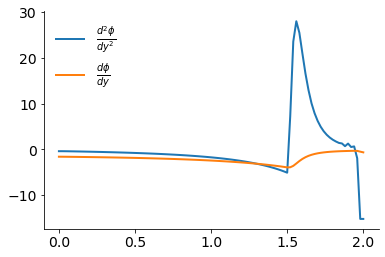

In [154]:
plt.plot(y_grid_cap,dϕdyy, label=r"$\frac{d^2\phi}{dy^2}$")
plt.plot(y_grid_cap,dϕdy, label=r"$\frac{d \phi}{dy}$")
plt.legend()

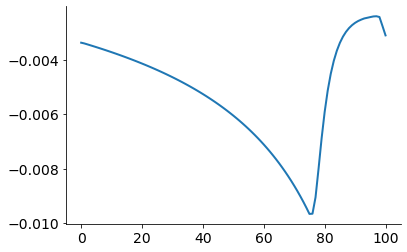

In [155]:
plt.plot(b)

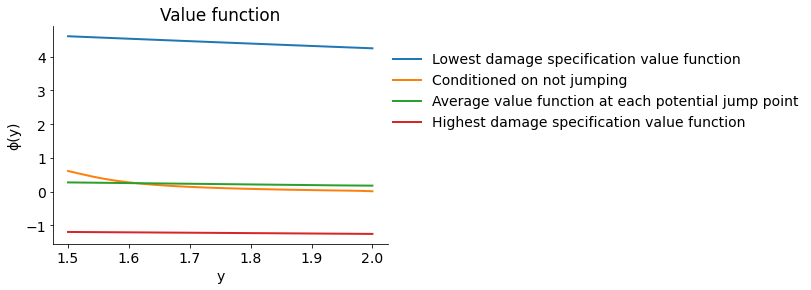

In [145]:
plt.plot(y_grid_cap[len(prepre_jump):], ϕ_ref[0, len(prepre_jump):], label="Lowest damage specification value function")

plt.plot(y_grid_cap[len(prepre_jump):], solution['φ'][len(prepre_jump):], label="Conditioned on not jumping")
# plt.plot(y_grid_cap, solution['φ'])
# plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
average_desination = np.average(ϕ_ref, axis=0)

plt.plot(y_grid_cap[len(prepre_jump):], average_desination[len(prepre_jump):], label="Average value function at each potential jump point")
plt.plot(y_grid_cap[len(prepre_jump):], ϕ_ref[-1, len(prepre_jump):], label="Highest damage specification value function")
plt.title('Value function')
plt.legend(loc=(1,0.5))
plt.xlabel("y")
plt.ylabel("ϕ(y)")
# plt.ylim(0)
# plt.savefig("value_functions.png", facecolor="w", edgecolor="w", dpi=500,  bbox_inches = "tight" )
plt.show()

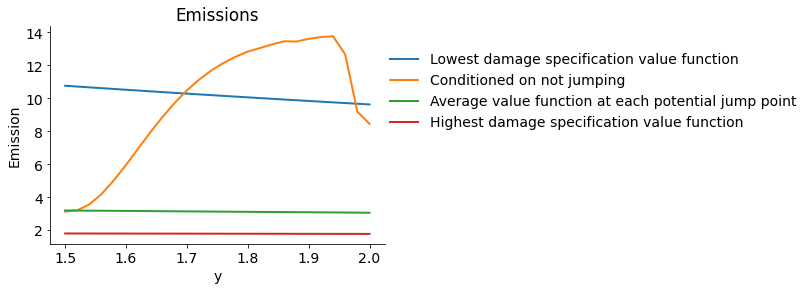

In [146]:
plt.plot(y_grid_cap[len(prepre_jump):], ems_ref[0, len(prepre_jump):], label="Lowest damage specification value function")

plt.plot(y_grid_cap[len(prepre_jump):], solution['ems'][len(prepre_jump):], label="Conditioned on not jumping")
# plt.plot(y_grid_cap, solution['φ'])
# plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
average_ems = np.average(ems_ref, axis=0)

plt.plot(y_grid_cap[len(prepre_jump):], average_ems[len(prepre_jump):], label="Average value function at each potential jump point")
plt.plot(y_grid_cap[len(prepre_jump):], ems_ref[-1, len(prepre_jump):], label="Highest damage specification value function")
plt.title('Emissions')
plt.legend(loc=(1,0.5))
plt.xlabel("y")
plt.ylabel("Emission")
# plt.ylim(0)
# plt.savefig("emissions.png", facecolor="w", edgecolor="w", dpi=500, bbox_inches = "tight" )
plt.show()

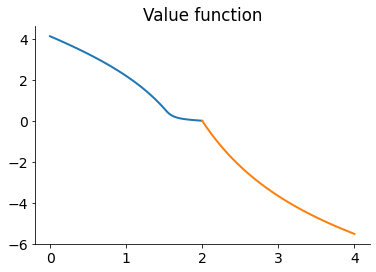

In [809]:
plt.plot(y_grid_cap,solution['φ'])
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
plt.title("Value function")
# plt.ylim(0)
plt.show()

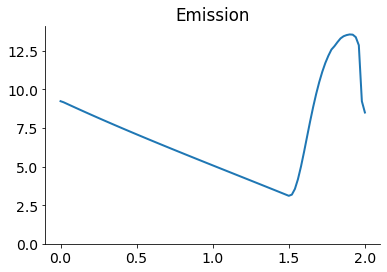

In [810]:
plt.plot(y_grid_cap,solution['ems'])
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
plt.title("Emission")
plt.ylim(0)
plt.show()

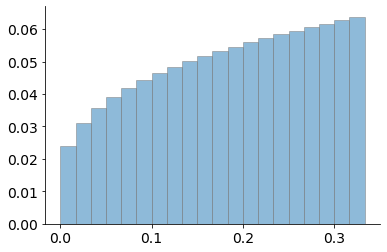

In [801]:
plt.hist(γ3_list, weights=g_list[:,-1]/np.sum(g_list[:,-1]), bins=20, ec="gray", alpha=0.5)
plt.show()

In [295]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


# ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
ϕ = -η*(y_grid_cap + y_grid_cap**2)

dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 0.2
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)  - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*(ϕ_ref)))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution2 = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.1166180227230164,	 ft error: 0.9128930730575903
episode: 2,	 ode error: 0.121190708566524,	 ft error: 0.20428025657999754
episode: 3,	 ode error: 0.12001513949639629,	 ft error: 0.12140206056536554
episode: 4,	 ode error: 0.11785044507348091,	 ft error: 0.11588834789360056
episode: 5,	 ode error: 0.1798343247629359,	 ft error: 0.1137755093923893
episode: 6,	 ode error: 0.11357442774492177,	 ft error: 0.11182319783215301
episode: 7,	 ode error: 0.11165603742826163,	 ft error: 0.11002729524481183
episode: 8,	 ode error: 0.10987737530687816,	 ft error: 0.10836592267644149
episode: 9,	 ode error: 0.10822203038658962,	 ft error: 0.10681922864609367
episode: 10,	 ode error: 0.10667538513075722,	 ft error: 0.10537112847157998
episode: 11,	 ode error: 0.10522486398623258,	 ft error: 0.10400929922429136
episode: 12,	 ode error: 0.10385990511431092,	 ft error: 0.10272428883370377
episode: 13,	 ode error: 0.10257139496073846,	 ft error: 0.10150715857435322
episode: 14,	 

episode: 152,	 ode error: 0.8343917311917115,	 ft error: 0.12846662251519536
episode: 153,	 ode error: 0.8305452355726644,	 ft error: 0.1222394068480992
episode: 154,	 ode error: 0.8268721918466984,	 ft error: 0.1163629075542083
episode: 155,	 ode error: 0.8233642389351274,	 ft error: 0.11076995061252815
episode: 156,	 ode error: 0.8200146171197507,	 ft error: 0.1054667581355817
episode: 157,	 ode error: 0.816816187716098,	 ft error: 0.10043635976823229
episode: 158,	 ode error: 0.8137621153195267,	 ft error: 0.0956629750595206
episode: 159,	 ode error: 0.8108458597594749,	 ft error: 0.09113189603080496
episode: 160,	 ode error: 0.8080611672999738,	 ft error: 0.0868294003592518
episode: 161,	 ode error: 0.805402061064572,	 ft error: 0.08274267307703864
episode: 162,	 ode error: 0.8028628310373161,	 ft error: 0.07885973503373833
episode: 163,	 ode error: 0.800438023889092,	 ft error: 0.07516937782338085
episode: 164,	 ode error: 0.7981224327894569,	 ft error: 0.07166110466570341
episode

episode: 273,	 ode error: 0.7489074293104029,	 ft error: 0.029511637801282742
episode: 274,	 ode error: 0.7488913693446118,	 ft error: 0.029371014846595322
episode: 275,	 ode error: 0.7488760263549475,	 ft error: 0.02923094288277195
episode: 276,	 ode error: 0.7488613686271195,	 ft error: 0.029091420939253432
episode: 277,	 ode error: 0.7488473658451358,	 ft error: 0.028952448004659903
episode: 278,	 ode error: 0.748833989029093,	 ft error: 0.028814023028929103
episode: 279,	 ode error: 0.7488212104758427,	 ft error: 0.02867614492524151
episode: 280,	 ode error: 0.748809003702353,	 ft error: 0.02853881257170343
episode: 281,	 ode error: 0.7487973433916454,	 ft error: 0.02840202481292131
episode: 282,	 ode error: 0.7487862053411605,	 ft error: 0.02826578046153383
episode: 283,	 ode error: 0.7487755664134439,	 ft error: 0.02813007829944203
episode: 284,	 ode error: 0.748765404489021,	 ft error: 0.027994917079314785
episode: 285,	 ode error: 0.7487556984214011,	 ft error: 0.02786029552565

episode: 402,	 ode error: 0.7485301653690152,	 ft error: 0.015393570546280433
episode: 403,	 ode error: 0.748530050052166,	 ft error: 0.015311294734703385
episode: 404,	 ode error: 0.7485299433287708,	 ft error: 0.01522936777026862
episode: 405,	 ode error: 0.7485298447490739,	 ft error: 0.015147788237135362
episode: 406,	 ode error: 0.7485297538815108,	 ft error: 0.015066554726064219
episode: 407,	 ode error: 0.7485296703119083,	 ft error: 0.014985665834412742
episode: 408,	 ode error: 0.748529593642722,	 ft error: 0.01490512016611989
episode: 409,	 ode error: 0.7485295234922985,	 ft error: 0.01482491633167049
episode: 410,	 ode error: 0.7485294594941707,	 ft error: 0.014745052948106352
episode: 411,	 ode error: 0.7485294012963786,	 ft error: 0.014665528638970748
episode: 412,	 ode error: 0.7485293485608174,	 ft error: 0.014586342034303978
episode: 413,	 ode error: 0.7485293009626117,	 ft error: 0.014507491770605618
episode: 414,	 ode error: 0.7485292581895108,	 ft error: 0.0144289764

episode: 534,	 ode error: 0.7485694023687995,	 ft error: 0.00710471389912648
episode: 535,	 ode error: 0.748570300812737,	 ft error: 0.007058504032340096
episode: 536,	 ode error: 0.7485711595496952,	 ft error: 0.007012506708108379
episode: 537,	 ode error: 0.748571980334713,	 ft error: 0.006966721198007342
episode: 538,	 ode error: 0.748572764845314,	 ft error: 0.006921146778267051
episode: 539,	 ode error: 0.7485735146849322,	 ft error: 0.006875782729658386
episode: 540,	 ode error: 0.7485742313861874,	 ft error: 0.006830628337319844
episode: 541,	 ode error: 0.7485749164140154,	 ft error: 0.006785682890699807
episode: 542,	 ode error: 0.748575571168659,	 ft error: 0.006740945683416655
episode: 543,	 ode error: 0.7485761969885291,	 ft error: 0.006696416013165507
episode: 544,	 ode error: 0.7485767951529361,	 ft error: 0.006652093181680474
episode: 545,	 ode error: 0.7485773668847037,	 ft error: 0.00660797649459699
episode: 546,	 ode error: 0.7485779133526651,	 ft error: 0.00656406526

episode: 668,	 ode error: 0.7484740372585239,	 ft error: 0.0025486635520532985
episode: 669,	 ode error: 0.7484737829158448,	 ft error: 0.002525798637242893
episode: 670,	 ode error: 0.7484735394823134,	 ft error: 0.002503074267945493
episode: 671,	 ode error: 0.7484733064760878,	 ft error: 0.0024804900280761544
episode: 672,	 ode error: 0.7484730834366045,	 ft error: 0.0024580455022205072
episode: 673,	 ode error: 0.7484728699236385,	 ft error: 0.0024357402756436386
episode: 674,	 ode error: 0.7484726655164067,	 ft error: 0.0024135739342145968
episode: 675,	 ode error: 0.7484724698127113,	 ft error: 0.002391546064419714
episode: 676,	 ode error: 0.74847228242812,	 ft error: 0.002369656253291552
episode: 677,	 ode error: 0.7484721029951819,	 ft error: 0.002347904088448871
episode: 678,	 ode error: 0.7484719311626797,	 ft error: 0.0023262891579722833
episode: 679,	 ode error: 0.7484717665949142,	 ft error: 0.002304811050453104
episode: 680,	 ode error: 0.748471608971019,	 ft error: 0.00

episode: 802,	 ode error: 0.7484675384834005,	 ft error: 0.0005739852839425907
episode: 803,	 ode error: 0.7484675322873463,	 ft error: 0.0005661871792028705
episode: 804,	 ode error: 0.7484675261446584,	 ft error: 0.0005584706891248459
episode: 805,	 ode error: 0.7484675200543037,	 ft error: 0.000550835311914355
episode: 806,	 ode error: 0.7484675140152965,	 ft error: 0.0005432805450222844
episode: 807,	 ode error: 0.7484675080266967,	 ft error: 0.0005358058852467096
episode: 808,	 ode error: 0.7484675020876062,	 ft error: 0.0005284108286796041
episode: 809,	 ode error: 0.7484674961971683,	 ft error: 0.000521094870817862
episode: 810,	 ode error: 0.7484674903545664,	 ft error: 0.0005138575065188888
episode: 811,	 ode error: 0.74846748455902,	 ft error: 0.0005066982300627743
episode: 812,	 ode error: 0.748467478809785,	 ft error: 0.0004996165351833781
episode: 813,	 ode error: 0.7484674731061509,	 ft error: 0.0004926119150683306
episode: 814,	 ode error: 0.7484674674474396,	 ft error: 

episode: 929,	 ode error: 0.7484670438609029,	 ft error: 7.030415602127249e-05
episode: 930,	 ode error: 0.7484670418274224,	 ft error: 6.896391765209842e-05
episode: 931,	 ode error: 0.7484670398174867,	 ft error: 6.76471403560086e-05
episode: 932,	 ode error: 0.7484670378309461,	 ft error: 6.635349856676243e-05
episode: 933,	 ode error: 0.74846703586765,	 ft error: 6.508266970239873e-05
episode: 934,	 ode error: 0.748467033927446,	 ft error: 6.383433416967677e-05
episode: 935,	 ode error: 0.7484670320101817,	 ft error: 6.260817541736685e-05
episode: 936,	 ode error: 0.7484670301157028,	 ft error: 6.140387984299167e-05
episode: 937,	 ode error: 0.7484670282438551,	 ft error: 6.022113690384856e-05
episode: 938,	 ode error: 0.7484670263944825,	 ft error: 5.905963903263256e-05
episode: 939,	 ode error: 0.7484670245674285,	 ft error: 5.7919081690727126e-05
episode: 940,	 ode error: 0.7484670227625355,	 ft error: 5.679916332823609e-05
episode: 941,	 ode error: 0.7484670209796453,	 ft error

episode: 1051,	 ode error: 0.7484669216751804,	 ft error: 1.327402873618766e-05
episode: 1052,	 ode error: 0.7484669213360049,	 ft error: 1.324018221726675e-05
episode: 1053,	 ode error: 0.748466921002304,	 ft error: 1.3205096489610213e-05
episode: 1054,	 ode error: 0.7484669206739903,	 ft error: 1.3168784995798433e-05
episode: 1055,	 ode error: 0.7484669203509777,	 ft error: 1.3131261542564943e-05
episode: 1056,	 ode error: 0.7484669200331818,	 ft error: 1.3094298798588255e-05
episode: 1057,	 ode error: 0.7484669197205197,	 ft error: 1.3063147177305723e-05
episode: 1058,	 ode error: 0.7484669194129095,	 ft error: 1.3030772416655623e-05
episode: 1059,	 ode error: 0.7484669191102715,	 ft error: 1.29971868001455e-05
episode: 1060,	 ode error: 0.748466918812527,	 ft error: 1.2962403017624524e-05
episode: 1061,	 ode error: 0.7484669185195987,	 ft error: 1.2926434109772345e-05
episode: 1062,	 ode error: 0.7484669182314105,	 ft error: 1.2889293474760422e-05
episode: 1063,	 ode error: 0.74846

episode: 1172,	 ode error: 0.748466904951556,	 ft error: 9.740202653318875e-06
episode: 1173,	 ode error: 0.7484669049401839,	 ft error: 9.715253110886835e-06
episode: 1174,	 ode error: 0.7484669049300309,	 ft error: 9.689570872328801e-06
episode: 1175,	 ode error: 0.7484669049210777,	 ft error: 9.66724124085161e-06
episode: 1176,	 ode error: 0.748466904913305,	 ft error: 9.64434867745112e-06
episode: 1177,	 ode error: 0.7484669049066935,	 ft error: 9.620724434888928e-06
episode: 1178,	 ode error: 0.7484669049012241,	 ft error: 9.596374705989064e-06
episode: 1179,	 ode error: 0.748466904896877,	 ft error: 9.571305954469977e-06
episode: 1180,	 ode error: 0.7484669048936329,	 ft error: 9.548410087045767e-06
episode: 1181,	 ode error: 0.7484669048914723,	 ft error: 9.526029896012034e-06
episode: 1182,	 ode error: 0.7484669048903757,	 ft error: 9.502932161176147e-06
episode: 1183,	 ode error: 0.7484669048903229,	 ft error: 9.479122848876642e-06
episode: 1184,	 ode error: 0.7484669048912946

episode: 1292,	 ode error: 0.7484669071285859,	 ft error: 5.739511470537195e-06
episode: 1293,	 ode error: 0.748466907141674,	 ft error: 5.692579345684123e-06
episode: 1294,	 ode error: 0.7484669071543438,	 ft error: 5.645669696185962e-06
episode: 1295,	 ode error: 0.7484669071665943,	 ft error: 5.598789640792745e-06
episode: 1296,	 ode error: 0.7484669071784242,	 ft error: 5.551946236082017e-06
episode: 1297,	 ode error: 0.7484669071898337,	 ft error: 5.5051464054045596e-06
episode: 1298,	 ode error: 0.7484669072008214,	 ft error: 5.458397032143125e-06
episode: 1299,	 ode error: 0.7484669072113876,	 ft error: 5.4117048575719195e-06
episode: 1300,	 ode error: 0.7484669072215318,	 ft error: 5.365076534147306e-06
episode: 1301,	 ode error: 0.7484669072312545,	 ft error: 5.3185186255078065e-06
episode: 1302,	 ode error: 0.748466907240556,	 ft error: 5.272037579828748e-06
episode: 1303,	 ode error: 0.7484669072494363,	 ft error: 5.225639769790291e-06
episode: 1304,	 ode error: 0.7484669072

episode: 1442,	 ode error: 0.7484669060145964,	 ft error: 9.496011621479283e-07
episode: 1443,	 ode error: 0.7484669060013184,	 ft error: 9.357310259971996e-07
episode: 1444,	 ode error: 0.7484669059881168,	 ft error: 9.220452001912349e-07
episode: 1445,	 ode error: 0.7484669059749933,	 ft error: 9.085418284371372e-07
episode: 1446,	 ode error: 0.7484669059619489,	 ft error: 8.952190855282538e-07
episode: 1447,	 ode error: 0.7484669059489849,	 ft error: 8.820750929672272e-07
episode: 1448,	 ode error: 0.7484669059361021,	 ft error: 8.69108029988297e-07
episode: 1449,	 ode error: 0.7484669059233013,	 ft error: 8.563160491803501e-07
episode: 1450,	 ode error: 0.7484669059105841,	 ft error: 8.436973120140578e-07
episode: 1451,	 ode error: 0.7484669058979512,	 ft error: 8.31250006605444e-07
episode: 1452,	 ode error: 0.7484669058854033,	 ft error: 8.189722811025035e-07
episode: 1453,	 ode error: 0.7484669058729416,	 ft error: 8.068623280621523e-07
episode: 1454,	 ode error: 0.7484669058605

episode: 1627,	 ode error: 0.7484669048992423,	 ft error: 5.8076725650835215e-08
episode: 1628,	 ode error: 0.7484669048979525,	 ft error: 5.722005980146605e-08
episode: 1629,	 ode error: 0.7484669048966829,	 ft error: 5.6375952794951445e-08
episode: 1630,	 ode error: 0.7484669048954333,	 ft error: 5.5544209232039066e-08
episode: 1631,	 ode error: 0.7484669048942039,	 ft error: 5.4724642595260775e-08
episode: 1632,	 ode error: 0.7484669048929936,	 ft error: 5.391706192625634e-08
episode: 1633,	 ode error: 0.7484669048918026,	 ft error: 5.3121258503097124e-08
episode: 1634,	 ode error: 0.7484669048906305,	 ft error: 5.233707245366759e-08
episode: 1635,	 ode error: 0.7484669048894768,	 ft error: 5.156432614228379e-08
episode: 1636,	 ode error: 0.7484669048883413,	 ft error: 5.080282861058549e-08
episode: 1637,	 ode error: 0.7484669048872238,	 ft error: 5.005242442734925e-08
episode: 1638,	 ode error: 0.7484669048861237,	 ft error: 4.9312935956891124e-08
episode: 1639,	 ode error: 0.74846

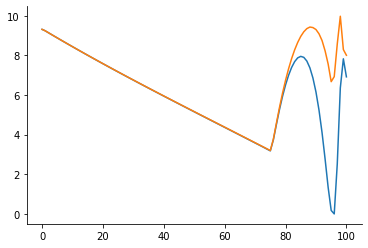

In [296]:
plt.plot(solution2["ems"])
plt.plot(solution["ems"])

In [186]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
#     - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*ϕ_ref))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution3 = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.004390852322982329,	 ft error: 0.22418337274887423
episode: 2,	 ode error: 0.029121730101864623,	 ft error: 0.17327722244026167
episode: 3,	 ode error: 0.04515459254603099,	 ft error: 0.14059848798580898
episode: 4,	 ode error: 0.05281790482083516,	 ft error: 0.1177845714167225
episode: 5,	 ode error: 0.054617421676391775,	 ft error: 0.10144153293081026
episode: 6,	 ode error: 0.05470282269088078,	 ft error: 0.08920647788599567
episode: 7,	 ode error: 0.054774514022959665,	 ft error: 0.07986975270741803
episode: 8,	 ode error: 0.05455476674510963,	 ft error: 0.07236267435314692
episode: 9,	 ode error: 0.054328161950900906,	 ft error: 0.06691734976267072
episode: 10,	 ode error: 0.05420144853166252,	 ft error: 0.06207855381482341
episode: 11,	 ode error: 0.05413879278715657,	 ft error: 0.05856350635756169
episode: 12,	 ode error: 0.05410697440406988,	 ft error: 0.05504806630689052
episode: 13,	 ode error: 0.05408957893492018,	 ft error: 0.052674503007888784
epi

episode: 152,	 ode error: 0.05406384158530156,	 ft error: 0.0054570090992012155
episode: 153,	 ode error: 0.05406383482202293,	 ft error: 0.005392617593163784
episode: 154,	 ode error: 0.05406382971677649,	 ft error: 0.005328853741080497
episode: 155,	 ode error: 0.05406382647855759,	 ft error: 0.005265763928064882
episode: 156,	 ode error: 0.05406382529025048,	 ft error: 0.005203385414029427
episode: 157,	 ode error: 0.05406382629604742,	 ft error: 0.00514174748326246
episode: 158,	 ode error: 0.0540638295888341,	 ft error: 0.005081529388544226
episode: 159,	 ode error: 0.054063835197587486,	 ft error: 0.005022185166999371
episode: 160,	 ode error: 0.05406384307642241,	 ft error: 0.00496350128861156
episode: 161,	 ode error: 0.05406385309562396,	 ft error: 0.004905496018886346
episode: 162,	 ode error: 0.054063865036303026,	 ft error: 0.004848181320945777
episode: 163,	 ode error: 0.05406387859052964,	 ft error: 0.00479156105495715
episode: 164,	 ode error: 0.054063893368663234,	 ft e

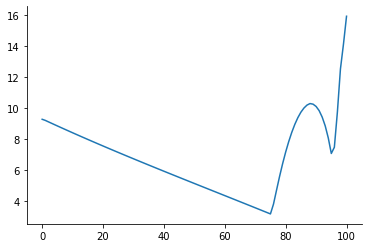

In [187]:
plt.plot(solution3['ems'])

In [320]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 0.5
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*(ϕ_ref ) ))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution4 = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.03355011616018995,	 ft error: 0.2819431580367157
episode: 2,	 ode error: 0.03144707250006177,	 ft error: 0.19118928611900543
episode: 3,	 ode error: 0.02774903284491423,	 ft error: 0.17103565553733246
episode: 4,	 ode error: 0.02493552274869751,	 ft error: 0.15452495258968613
episode: 5,	 ode error: 0.025449232588863696,	 ft error: 0.14055226677820132
episode: 6,	 ode error: 0.029133605067271966,	 ft error: 0.12862341370023178
episode: 7,	 ode error: 0.0311021306380131,	 ft error: 0.11833390159298651
episode: 8,	 ode error: 0.03388108109620272,	 ft error: 0.10974725235452709
episode: 9,	 ode error: 0.03515212669539189,	 ft error: 0.10221370017293552
episode: 10,	 ode error: 0.0351341401990303,	 ft error: 0.0955449382021385
episode: 11,	 ode error: 0.03496216137085204,	 ft error: 0.09001209999636073
episode: 12,	 ode error: 0.035080648235554714,	 ft error: 0.0848046909082012
episode: 13,	 ode error: 0.03524135895741464,	 ft error: 0.08062164210229317
episode: 1

episode: 176,	 ode error: 0.04573924456236759,	 ft error: 0.012412311116323238
episode: 177,	 ode error: 0.04573923021156409,	 ft error: 0.012331560058833624
episode: 178,	 ode error: 0.04573921529051541,	 ft error: 0.012244403101544954
episode: 179,	 ode error: 0.04573919982370042,	 ft error: 0.012150671069934837
episode: 180,	 ode error: 0.045739183837068535,	 ft error: 0.01207576092640572
episode: 181,	 ode error: 0.045739167357867566,	 ft error: 0.011999541329602792
episode: 182,	 ode error: 0.04573915041447173,	 ft error: 0.011917262548869267
episode: 183,	 ode error: 0.04573913303621411,	 ft error: 0.011828763569377898
episode: 184,	 ode error: 0.04573911525322015,	 ft error: 0.011751150209847516
episode: 185,	 ode error: 0.045739097096246725,	 ft error: 0.011678609763308145
episode: 186,	 ode error: 0.045739078596524096,	 ft error: 0.01160031513122739
episode: 187,	 ode error: 0.04573905978560487,	 ft error: 0.011516113461611965
episode: 188,	 ode error: 0.04573904069521601,	 ft

episode: 344,	 ode error: 0.045738071650373704,	 ft error: 0.004267900985238882
episode: 345,	 ode error: 0.04573807308250215,	 ft error: 0.004221168776448181
episode: 346,	 ode error: 0.04573807443217372,	 ft error: 0.004172894377754588
episode: 347,	 ode error: 0.04573807570238628,	 ft error: 0.004123095864956738
episode: 348,	 ode error: 0.0457380768970743,	 ft error: 0.004071795668696865
episode: 349,	 ode error: 0.045738078021041934,	 ft error: 0.004019020687605845
episode: 350,	 ode error: 0.0457380790798811,	 ft error: 0.003964802376206222
episode: 351,	 ode error: 0.045738080079871395,	 ft error: 0.003909176805187542
episode: 352,	 ode error: 0.04573808102786882,	 ft error: 0.003852184691842453
episode: 353,	 ode error: 0.04573808193118212,	 ft error: 0.003793871398805493
episode: 354,	 ode error: 0.04573808279744103,	 ft error: 0.0037342868994372225
episode: 355,	 ode error: 0.045738083634456805,	 ft error: 0.0036734857086742068
episode: 356,	 ode error: 0.04573808445008337,	 

episode: 494,	 ode error: 0.04573821783235705,	 ft error: 4.432250307218055e-06
episode: 495,	 ode error: 0.04573821788966394,	 ft error: 4.153008108076506e-06
episode: 496,	 ode error: 0.045738217943571025,	 ft error: 3.890941796313996e-06
episode: 497,	 ode error: 0.045738217994271003,	 ft error: 3.6450317910663443e-06
episode: 498,	 ode error: 0.04573821804194651,	 ft error: 3.4143165450473134e-06
episode: 499,	 ode error: 0.04573821808677048,	 ft error: 3.1978893773043637e-06
episode: 500,	 ode error: 0.04573821812890637,	 ft error: 2.9948955333480853e-06
episode: 501,	 ode error: 0.04573821816850896,	 ft error: 2.8045293412048977e-06
episode: 502,	 ode error: 0.045738218205724435,	 ft error: 2.6260315522108613e-06
episode: 503,	 ode error: 0.045738218240691055,	 ft error: 2.458686809703181e-06
episode: 504,	 ode error: 0.04573821827353944,	 ft error: 2.301821194095055e-06
episode: 505,	 ode error: 0.04573821830439306,	 ft error: 2.1547999864424128e-06
episode: 506,	 ode error: 0.0

episode: 641,	 ode error: 0.045738218764934405,	 ft error: 1.0787161386360822e-08
episode: 642,	 ode error: 0.04573821876495576,	 ft error: 1.056864462611884e-08
episode: 643,	 ode error: 0.04573821876497686,	 ft error: 1.0354071378060326e-08
episode: 644,	 ode error: 0.04573821876499755,	 ft error: 1.0143399009621135e-08
episode: 645,	 ode error: 0.045738218765018074,	 ft error: 9.936604428162354e-09


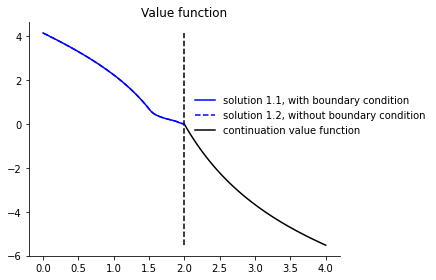

In [324]:
plt.plot(y_grid_cap, solution['φ'], label="solution 1.1, with boundary condition", color="blue")
plt.plot(y_grid_cap, solution4['φ'], label="solution 1.2, without boundary condition", 
         color="blue", linestyle="dashed",
        )

# plt.plot(y_grid_cap, solution['φ'], label="solution 2.1, with boundary condition", color="red")
# plt.plot(y_grid_cap, solution4['φ'], label="solution 2.2, without boundary condition", color="red", 
#         linestyle="dashed")
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="continuation value function", color="black")
# plt.plot(ϕ_ref.T)
plt.vlines(2, ϕ_bound.min(), solution4["φ"].max(), color="black", linestyle="dashed")
plt.legend(loc=(0.52,0.5))
plt.title('Value function')
plt.tight_layout()
# plt.savefig("../figures/20_damages/value_match_0510.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

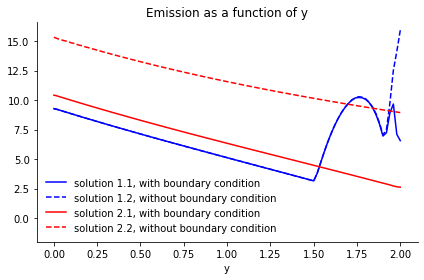

In [158]:
plt.plot(y_grid_cap, solution2['ems'], label="solution 1.1, with boundary condition", color="blue")
plt.plot(y_grid_cap, solution3['ems'], label="solution 1.2, without boundary condition ", color="blue",
        linestyle="dashed")

plt.plot(y_grid_cap, solution['ems'], label="solution 2.1, with boundary condition", color="red")
plt.plot(y_grid_cap, solution4['ems'], label="solution 2.2, without boundary condition",
        color="red", linestyle="dashed")
# plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="continuation value function")
# plt.plot(ϕ_ref.T)
plt.ylim(-2)
plt.legend(loc=3)
plt.xlabel('y')
plt.title("Emission as a function of y")
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_match.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

In [537]:
dt = 1/4

In [538]:
def no_jump_simulation(ems, dt):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [539]:
def no_jump_simulation_long(ems, dt):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [540]:
simul_no1 = no_jump_simulation(ems=solution['ems'], dt=1/4)

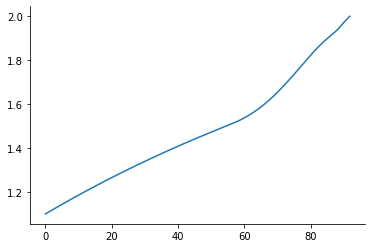

In [541]:
plt.plot(np.arange(0, len(simul_no1[1])*dt, dt), simul_no1[1])

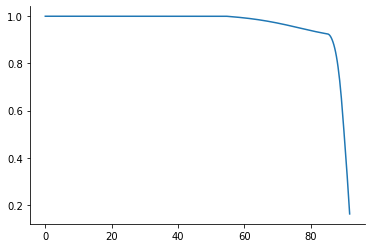

In [543]:
# year = np.arange(0, T-τ, τ)
plt.plot(np.arange(0, len(simul_no1[-1])*dt, dt), simul_no1[-1])
# plt.ylim(0)

In [544]:
len(ems_list), jump_interval[-1]

(26, 2.0000000000000004)

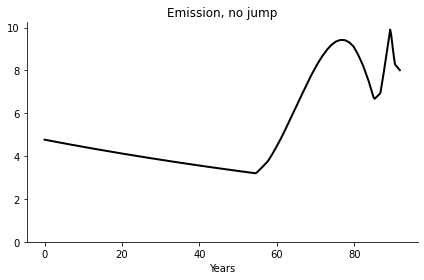

In [545]:
# et_tests = []
# for i in range(len(dmg_weight)):
#     et_test, _, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
#     plt.plot(et_test)
#     et_tests.append(et_test)
    
plt.plot(np.arange(0, len(simul_no1[0])*dt, dt), simul_no1[0], color="black", linewidth=2)    
plt.xlabel('Years')
plt.title("Emission, no jump")
plt.tight_layout()
plt.ylim(0)
# plt.savefig("ems.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

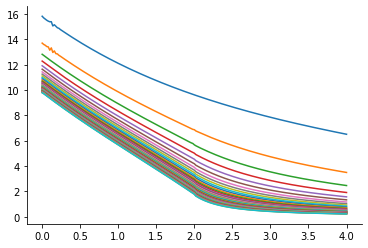

In [546]:
plt.plot(y_grid,ems_list[-1].T)
plt.show()

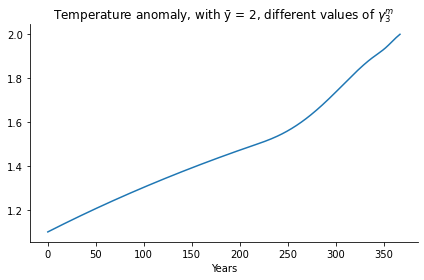

In [547]:
# yt_refs = []
# for i in range(len(dmg_weight)):
#     _, yt_ref, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
#     plt.plot(yt_ref, label="$\gamma2$")
#     yt_refs.append(yt_ref)

# plt.legend()    
plt.plot(simul_no1[1])
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
plt.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

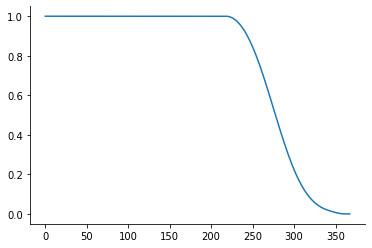

In [549]:
jump_prob = 1 - simul_no1[-1]
integral = np.cumsum(jump_prob)
conti_prob = np.exp(- integral)
plt.plot(conti_prob)

In [552]:
prob_no_jump = np.cumprod(simul_no1[-1])
prob_no_jump.shape, simul_no1[1].shape

((368,), (368,))

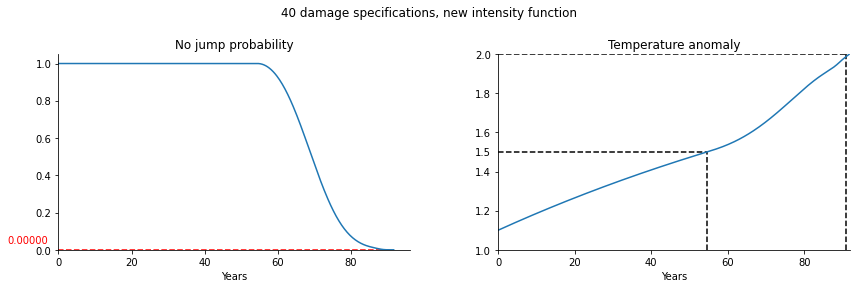

In [555]:
import matplotlib.transforms as transforms

yt = simul_no1[1]
T_jump = (np.abs(yt-1.5).argmin())*dt
T_stop = len(simul_no1[1])*dt


Years = np.arange(0, T_stop, dt)
prob_no_jump = np.cumprod(simul_no1[-1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('{} damage specifications, new intensity function'.format(len(dmg_weight)), y=0.99)


ax1.plot(Years, np.cumprod(simul_no1[-1]))
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")


ax2.plot(Years, simul_no1[1])
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop-1, color="black", linestyle="dashed")
ax2.vlines(T_stop-1, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, T_stop) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax1.text(0,1.5, 1.5, color="black", transform=trans, 
        ha="right", va="center")

fig.tight_layout()

# fig.savefig('prob_anomaly_new.png',dpi=500, facecolor="w", edgecolor="w")

In [556]:
T_jump

54.5

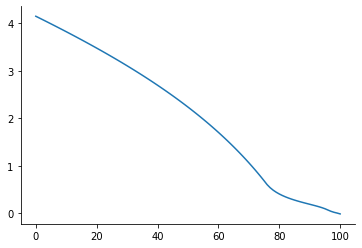

In [557]:
ϕ_list.shape
plt.plot(ϕ)

In [558]:
def jump_simulation(ems, dt):
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
    ems_list = res_dict['ems_list']
    ϕ_list = res_dict['φ_list']
    y0 = 1.1
    y_lower = 1.5
    T_year = 120
    T = int(T_year/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1 - intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1- intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    print(T_final)
    T_extra = T - T_final
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        print(t)
        e_i = np.interp(y, y_grid_cap, ems)
#         prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)

        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        et[t] = e_i
        probt[t] = 1 - intensity*dt
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        PROB[:, t] = prob_no[t]
        EMS[:, t] = et[t]
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        print(t)
        if t == T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                PROB[dmg+1, t] = intensity*dt*dmg_weight[dmg]
                EMS[dmg+1, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[dmg+1, t] =  yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dt*dmg_weight[dmg]
            
                EMS[id_dmg, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = yt[t]
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
        
    for t in range(T_final, T+1):
        print(t)
        EMS[0, t] = EMS[0,t-1]
        probt[t] = 0
        prob_no[: t+1] = np.cumprod(probt[:t+1])
        PROB[0, t] = prob_no[t]
        YS[0, t] = y
        et[t] = et[t-1]
        yt[t] = y
        y = y + et[t]*θ_mean*dt
        for time in range(T_final-T_jump):
            for dmg in range(len(dmg_weight)):
                id_dmg = dmg + time*len(dmg_weight) +1
                loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, PROB, GS, YS, EMS

In [560]:
simul_full_1 = jump_simulation(solution['ems'], dt=1/4)

219
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

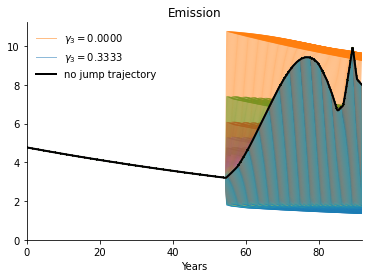

In [561]:
ems_test = simul_full_1[-1]


Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(simul_full_1[0])
plt.plot(Time, simul_no1[0], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
simul_full_1[-3][:,-1].sum()
# plt.plot(simul_full_1[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, Time.max())
plt.legend(loc=2)
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

In [639]:
prob_110.max(), ems_test[:, Periods].argmax(), simul_full_1[-4][12401, Periods]

(0.0003594836334282265, 12401, 1.1214687751933956e-22)

In [615]:
ems_test[:, Periods].max()

9.627332411265066

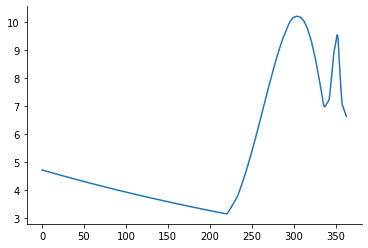

In [548]:
plt.plot(simul_no2[0])

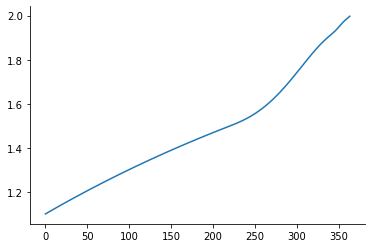

In [549]:
simul_no2 = no_jump_simulation(ems=solution2['ems'], dt=1/4)
plt.plot(simul_no2[1])

In [550]:
simul_full_2 = jump_simulation(ems=solution2['ems'], dt=1/4)

221
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

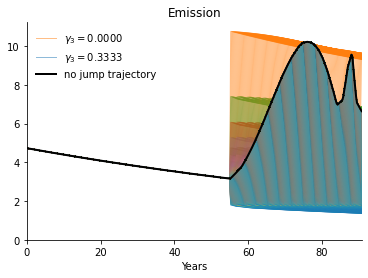

In [551]:
ems_test = simul_full_2[-1]
Periods = len(simul_full_2[0])
Time = np.arange(0, Periods*dt, dt)
color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(simul_full_1[0])
plt.plot(Time, simul_no2[0], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
simul_full_1[-3][:,-1].sum()
# plt.plot(simul_full_1[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, Time.max())
plt.legend(loc=2)
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

IndexError: index 2321 is out of bounds for axis 0 with size 2321

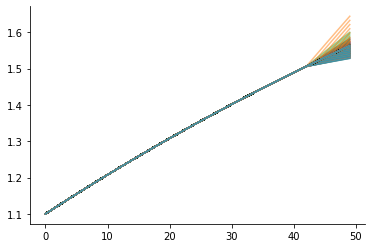

In [552]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :50], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

IndexError: index 2321 is out of bounds for axis 0 with size 2321

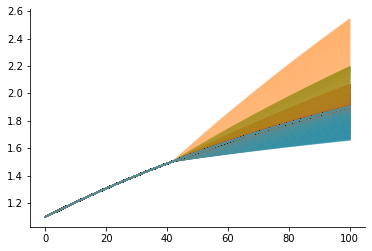

In [553]:
# 120
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :120], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [554]:
np.interp(3, y_grid_cap, ems_ref[0])

9.625855283479735

(0.0, 1.05)

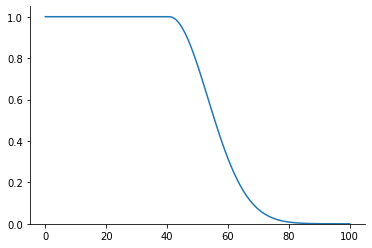

In [555]:
plt.plot(solu[3][:len(yt)])
plt.ylim(0)

In [556]:
solu[3]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 9.95529315e-01, 9.84885087e-01,
       9.68269860e-01, 9.45994283e-01, 9.18467478e-01, 8.86184524e-01,
       8.49711722e-01, 8.09670101e-01, 7.66717954e-01, 7.21533031e-01,
       6.74795044e-01, 6.27169152e-01, 5.79290896e-01, 5.31753082e-01,
      

In [557]:
solu[3], solu[-2][1], solu[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = solu[-4][:,100]

prob_test.sum()

0.9999715834206131

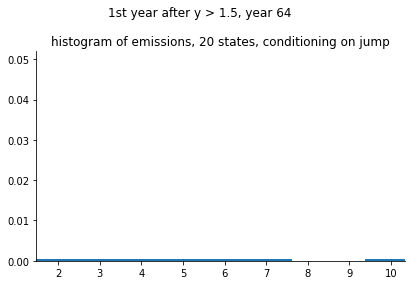

In [558]:
ems1 = solu[-1][:,65]
ems1 = ems1[np.nonzero(ems1)]
y1 = solu[-3][:,65]
y1 = y1[np.nonzero(y1)]
prob1 = solu[-2][:, 65]
prob1 = prob1[np.nonzero(prob1)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("1st year after y > 1.5, year 64")
axes.bar(ems1[1:], height=prob1[1:]/np.sum(prob1[1:]))
axes.set_xlim(np.min(ems1), np.max(ems1))
# axes[1].bar(y1[1:], height=prob1[1:]/np.sum(prob1[1:]))


axes.set_title("histogram of emissions, 20 states, conditioning on jump")
# axes[1].set_title("histogram of temperature anomaly, 20 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
axes.set_xlim(np.min(ems1), np.max(ems1))
# plt.savefig("histogram_1.png", facecolor="w", edgecolor="w")
plt.show()

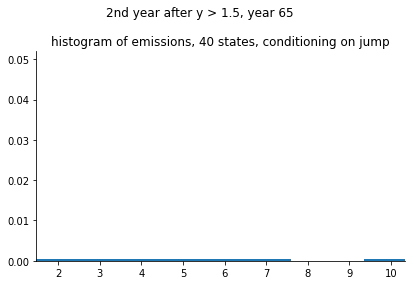

In [321]:
ems2 = solu[-1][:,66]
ems2 = ems2[np.nonzero(ems2)]
y2 = solu[-3][:, 66]
y2 = y2[np.nonzero(y2)]
prob2 = solu[-2][:, 66]
prob2 = prob2[np.nonzero(prob2)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("2nd year after y > 1.5, year 65")
axes.bar(ems2[1:], height=prob2[1:]/np.sum(prob2[1:]))
# axes[0].set_xlim(np.)
# axes.bar(y2[1:], prob2[1:]/np.sum(prob2[1:]) )
axes.set_xlim(np.min(ems1), np.max(ems1))
axes.set_title("histogram of emissions, 40 states, conditioning on jump")
# axes.set_title("histogram of temperature anomaly, 41 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
# axes[1].set_xlim(1.5, 1.8)
# plt.savefig("histogram_2.png", facecolor="w", edgecolor="w")
plt.show()

In [322]:
len(yt)

119

In [561]:
t = len(yt)-1
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

IndexError: index 476 is out of bounds for axis 1 with size 101

In [562]:
y_110[0], yt[-1], prob_110.sum()

(1.999289770184682, 1.999289770184682, 3.9995002089386094)

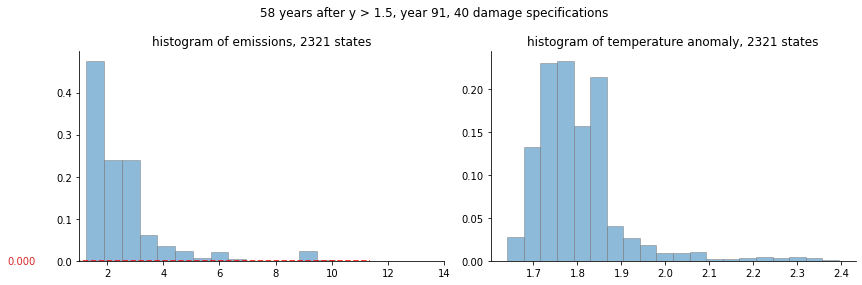

In [325]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
t = 91
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)),t, len(dmg_weight)))
axes[0].hist(ems_110, weights=prob_110, 
             bins=np.linspace(0, 12, 20), 
             alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=20,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

p = axes[0].patches

distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.1,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")
# no jump
# axes[0].hlines(distribution[np.nonzero(distribution)][-2], 0, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# axes[0].text(-0.1,distribution[np.nonzero(distribution)][-2], "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="right", va="center")
axes[0].set_xlim(1,14)
# axes[1].set_xlim(1.6, 3.2)
# axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("histogram_new.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

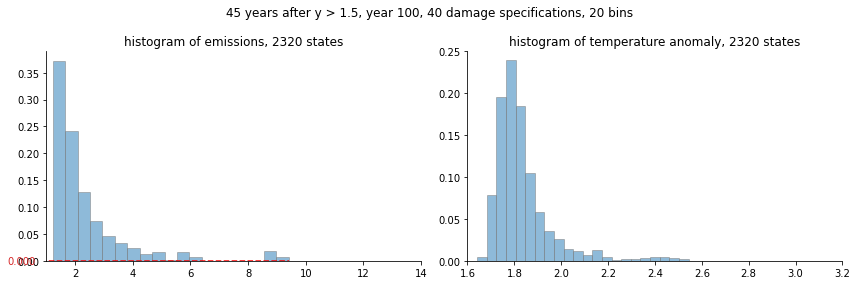

In [326]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-55, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [544]:
prob_110.sum()

3.9995002089386094

In [590]:
ems_110.max()

9.629877124193415

(array([4.05265392e-01, 2.35199906e-01, 1.21561860e-01, 7.22603914e-02,
        4.01229651e-02, 2.79367291e-02, 2.21715486e-02, 2.14729382e-02,
        3.98064802e-03, 6.34327134e-03, 1.79984609e-02, 6.81144397e-04,
        4.74513217e-06, 3.62589153e-12, 0.00000000e+00, 0.00000000e+00,
        1.40461567e-02, 1.07414508e-02, 2.11549079e-04, 8.43410072e-07]),
 array([1.12819351, 1.55327769, 1.97836187, 2.40344606, 2.82853024,
        3.25361442, 3.6786986 , 4.10378278, 4.52886696, 4.95395114,
        5.37903532, 5.8041195 , 6.22920368, 6.65428786, 7.07937204,
        7.50445622, 7.9295404 , 8.35462458, 8.77970876, 9.20479294,
        9.62987712]),
 <BarContainer object of 20 artists>)

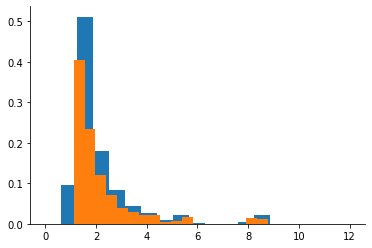

In [623]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]

plt.hist(ems_test[:, t], weights=prob_110, bins=np.linspace(0,12,20))
plt.hist(ems_110, weights=prob_110, bins=20)

In [610]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])
ems_110 = simul_full_1[-1][:, t]
ems_test[:, t].max(), ems_110.max(), Periods, ems_test[41]

(9.627332411265066,
 9.627332411265066,
 477,
 array([ 5.96591883,  5.95552803,  5.94515533,  5.9348007 ,  5.9244641 ,
         5.9141455 ,  5.90384488,  5.89356219,  5.88330641,  5.87307133,
         5.86285405,  5.85265455,  5.84247279,  5.83230875,  5.82216238,
         5.81203823,  5.80193782,  5.79185497,  5.78178964,  5.77174181,
         5.76171143,  5.75169849,  5.74170295,  5.73173433,  5.72178305,
         5.71184905,  5.70193229,  5.69203275,  5.6821504 ,  5.6722852 ,
         5.66244114,  5.65261865,  5.6428132 ,  5.63302475,  5.62325329,
         5.61349878,  5.60376118,  5.59404048,  5.58434292,  5.57466332,
         5.56500049,  5.55535441,  5.54572506,  5.53611239,  5.52651639,
         5.51693777,  5.50738138,  5.49784154,  5.48831823,  5.47881142,
         5.46932107,  5.45984716,  5.45038966,  5.44095008,  5.43153067,
         5.42212757,  5.41274075,  5.40337018,  5.39401583,  5.38467768,
         5.37535569,  5.36605135,  5.35676597,  5.34749666,  5.33824339,
     

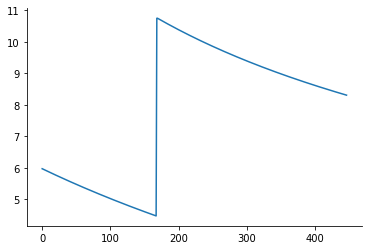

In [602]:
plt.plot(ems_test[81, :447])

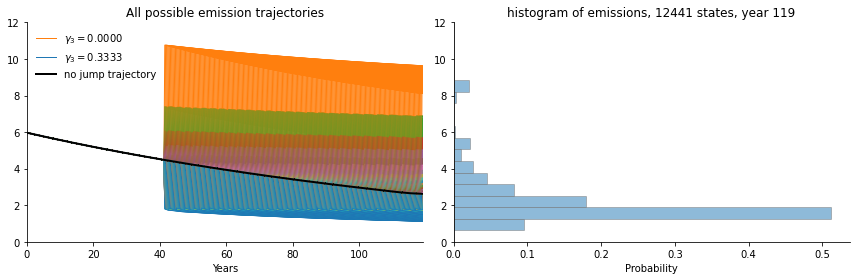

In [619]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    ax1.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)


ax1.plot(Time, simul_no1[0], color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_1[0])*dt)
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, 
         bins=np.linspace(0,12,20),
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])


# ax2.set_xlim(1,14)
ax2.set_ylim(0,12)
ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 119".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_1.png",facecolor="w", edgecolor="w", dpi=500)

In [586]:
len(simul_full_2[0])/4

91.0

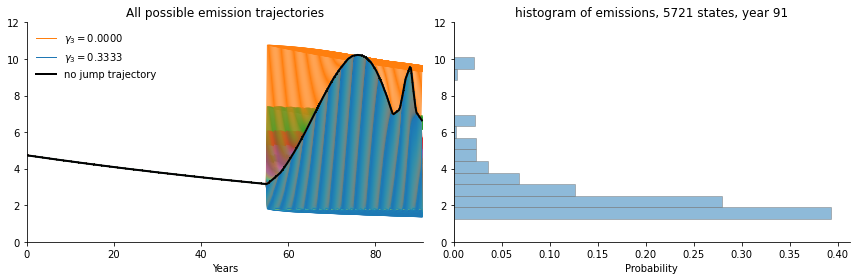

In [629]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_2[-1]
Periods = len(simul_full_2[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no2[0])-1
ems_110 = simul_full_2[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_2[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_2[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(simul_full_2[0])
ax1.plot(Time, simul_no2[0], color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_2[0])*dt)
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, 
         bins=np.linspace(0,12,20),
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

# ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
# ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
#         ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,12)
ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 91".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_2.png",facecolor="w", edgecolor="w", dpi=1000)

In [212]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

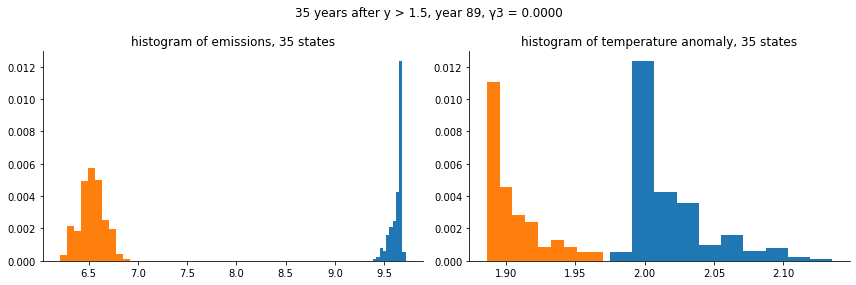

In [213]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
np.abs(distribution).argmax()

In [ ]:
bins[2], bins[3]

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [ ]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')